# **CuPL**

# **Prepare The Execution Environment**

In [1]:
# Change the path if necessary
datasets_path = 'datasets'

import sys
import os

# Deploy AML code in colab
if 'google.colab' in sys.modules:
    if not os.path.exists('/content/applied-ml/'):
        !wget -q https://raw.githubusercontent.com/tsunrise/colab-github/main/colab_github.py
        import colab_github
        colab_github.github_auth(persistent_key=False)

        %cd /content/
        !git clone git@github.com:oz-e/applied-ml.git
        if not os.path.exists('/content/applied-ml/'):
            raise Exception('Please follow the instructions to add the SSH key to your account in order to clone private repo')

    %cd /content/applied-ml/

    # Install any other requirements (to be converted to requirements.txt)
    !pip install openai-clip

In [2]:
if not os.path.exists('CuPL'):
    !git clone https://github.com/sarahpratt/CuPL.git

In [3]:
import aml.datasets
import numpy as np
import torch
import clip
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from CuPL.imagenet_prompts.standard_image_prompts import imagenet_templates
import sklearn.manifold
import sklearn.metrics

# **Configurations**

In [4]:
# @title Hyperparameters For Filtering Outliers In CuPL Texts

# @markdown Minimum Mean Similarity Of Texts
similarity_mean_threshold = 0.7 #@param {type:"number"}

In [5]:
# @title Other Configurations

# @markdown Test On Which Dataset
test_dataset_name = 'caltech'   #@param ['airplane', 'caltech', 'dtd', 'flower', 'food', 'pets', 'ucf']

# @markdown Which CuPL Prompt To Use
cupl_prompt_type = 'full'       #@param ['full', 'base']

# **Processings**

## Create The CLIP Model And Dataset Object

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model, preprocess = clip.load('ViT-B/16', device=device, jit=False)

In [7]:
match test_dataset_name:
    case 'airplane':
        dataset_test = aml.datasets.FGVCAircraft(datasets_path, split='test', transform=preprocess)
        PATH_TO_PROMPTS = f'./CuPL/all_prompts/{cupl_prompt_type}_prompts/airplane_prompts_{cupl_prompt_type}.json'
    case 'caltech':
        dataset_test = aml.datasets.Caltech101(datasets_path, split='test', transform=preprocess)
        PATH_TO_PROMPTS = f'./CuPL/all_prompts/{cupl_prompt_type}_prompts/cal_prompts_{cupl_prompt_type}.json'
    case 'dtd':
        dataset_test = aml.datasets.DTD(datasets_path, split='test', transform=preprocess)
        PATH_TO_PROMPTS = f'./CuPL/all_prompts/{cupl_prompt_type}_prompts/texture_prompts_{cupl_prompt_type}.json'
    case 'flower':
        dataset_test = aml.datasets.Flowers102(datasets_path, split='test', transform=preprocess)
        PATH_TO_PROMPTS = f'./CuPL/all_prompts/{cupl_prompt_type}_prompts/flower_prompts_{cupl_prompt_type}.json'
    case 'food':
        dataset_test = aml.datasets.Food101(datasets_path, split='test', transform=preprocess)
        PATH_TO_PROMPTS = f'./CuPL/all_prompts/{cupl_prompt_type}_prompts/food_prompts_{cupl_prompt_type}.json'
    case 'pets':
        dataset_test = aml.datasets.OxfordIIITPet(datasets_path, split='test', transform=preprocess)
        PATH_TO_PROMPTS = f'./CuPL/all_prompts/{cupl_prompt_type}_prompts/pets_prompts_{cupl_prompt_type}.json'
    case 'ucf':
        dataset_test = aml.datasets.UCF101(datasets_path, split='test', transform=preprocess)
        PATH_TO_PROMPTS = f'./CuPL/all_prompts/{cupl_prompt_type}_prompts/ucf_prompts_{cupl_prompt_type}.json'

cls_names_sorted = dataset_test.classnames

## Calculate Text Features

### Text Features Using Class Name Directly

In [8]:
# Create class name features
with torch.no_grad():
    cls_name_label_ids = np.arange(len(cls_names_sorted))
    cls_name_features_cuda = model.encode_text(clip.tokenize(cls_names_sorted).to(device))
    cls_name_features_cuda /= cls_name_features_cuda.norm(dim=-1, keepdim=True)
    cls_name_features = cls_name_features_cuda.cpu().numpy()

    # Fill diagonal for better visibility
    cls_name_masked_similarity = (cls_name_features_cuda @ cls_name_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

### Text Features Using 80 Templates

In [9]:
def calc_features(encoder, items_dict):
    with torch.no_grad():
        label_ids = []
        features_cuda = []
        cls_features_cuda = []
        for label_id in tqdm(range(len(cls_names_sorted))):
            items = items_dict.pop(label_id)
            label_ids.append([label_id] * len(items))
            class_embeddings = encoder(items)
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            features_cuda.append(class_embeddings)
            cls_features_cuda.append(class_embedding)
        label_ids = np.hstack(label_ids)
        features = torch.vstack(features_cuda).cpu().numpy()
        cls_features_cuda = torch.vstack(cls_features_cuda)

        # Fill diagonal for better visibility
        masked_similarity = (cls_features_cuda @ cls_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

    return label_ids, features, features_cuda, cls_features_cuda, masked_similarity

In [10]:
def encode_text(texts):
    with torch.no_grad():
        return model.encode_text(clip.tokenize(texts).to(device))

In [11]:
# Create template text features
template_label_texts_list = {label_id: [template.format(cls_name) for template in imagenet_templates] for label_id, cls_name in enumerate(cls_names_sorted)}
template_label_ids, template_text_features, template_text_features_cuda, template_cls_features_cuda, template_masked_similarity = calc_features(encode_text, template_label_texts_list)

100%|██████████| 100/100 [00:01<00:00, 51.05it/s]


### Text Features Using Original CuPL (Unfiltered)

In [12]:
# Mapping between CuPL and cls_name
match test_dataset_name:
    case 'caltech':
        special_class_mapping = {
            'centered face': 'face',
            'side of a car': 'car_side',
            'body of a cougar cat': 'cougar_body',
            'face of a cougar cat': 'cougar_face',
            'head of a crocodile': 'crocodile_head',
            'head of a flamingo': 'flamingo_head',
            'snoopy (cartoon beagle)': 'snoopy',
            'yin and yang symbol': 'yin_yang',
        }
    case 'flower':
        special_class_mapping = {
            'globe flower': 'globe-flower',
            'pink and yellow dahlia': 'pink-yellow dahlia',
            'air plant': 'ball moss',
        }
    case 'ucf':
        special_class_mapping = {
            'Hand Stand Pushups': 'Handstand_Pushups'
        }
    case _:
        special_class_mapping = {}

In [13]:
with open(PATH_TO_PROMPTS) as f:
    cupl_prompts_file = json.load(f)

# Lookup CuLP prompts from cls_name
original_cupl_prompts = {}

for cupl_cls_name, texts in cupl_prompts_file.items():
    cls_name = special_class_mapping.get(cupl_cls_name, cupl_cls_name)
    match test_dataset_name:
        case 'caltech' | 'dtd' | 'food' | 'ucf':
            cls_name = cls_name.replace(' ', '_')
        case 'pets':
            cls_name = cls_name.replace(' ', '_').lower()
    if cls_name not in cls_names_sorted:
        continue
    original_cupl_prompts[cls_name] = texts

In [14]:
# Create original cupl text features
original_cupl_label_texts_list = {label_id: original_cupl_prompts[cls_name] for label_id, cls_name in enumerate(cls_names_sorted)}
original_cupl_label_ids, original_cupl_text_features, original_cupl_text_features_cuda, original_cupl_cls_features_cuda, original_cupl_masked_similarity = calc_features(encode_text, original_cupl_label_texts_list)

100%|██████████| 100/100 [00:00<00:00, 117.86it/s]


### Text Features Using Filtered CuPL
A new method is proposed to filter CuPL texts by comparing the text embeddings among others in the same class

In [15]:
# Filter out outliers in cupl text features
with torch.no_grad():
    # Remove duplicates
    unique_cupl_prompts = {label_id: list(dict.fromkeys(original_cupl_prompts[cls_name])) for label_id, cls_name in enumerate(cls_names_sorted)}
    _, _, unique_cupl_text_features_cuda, _, _ = calc_features(encode_text, unique_cupl_prompts.copy())

    # Filter by mean of similarity
    unique_cupl_text_similarity = [(features_cuda @ features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy() for features_cuda in unique_cupl_text_features_cuda]
    unique_cupl_text_similarity_mean = [np.nanmean(similarity, axis=0) for similarity in unique_cupl_text_similarity]
    filtered_cupl_prompts = {label_id: [text for text, similarity_mean in zip(texts, similarity_means) if similarity_mean >= similarity_mean_threshold] for (label_id, texts), similarity_means in zip(unique_cupl_prompts.items(), unique_cupl_text_similarity_mean)}

    # Print filtered prompts
    outlier_cupl_prompts = {label_id: [text for text, similarity_mean in zip(texts, similarity_means) if similarity_mean < similarity_mean_threshold] for (label_id, texts), similarity_means in zip(unique_cupl_prompts.items(), unique_cupl_text_similarity_mean)}
    top_filtered_label_id = None
    top_filtered_count = 0
    for label_id, texts in outlier_cupl_prompts.items():
        filtered_count = len(texts)
        if filtered_count != 0:
            print(f'Filtered {filtered_count} outliers for ({label_id}){cls_names_sorted[label_id]}')
            print(texts)
            print()
            if filtered_count > top_filtered_count:
                top_filtered_count = filtered_count
                top_filtered_label_id = label_id

100%|██████████| 100/100 [00:00<00:00, 138.14it/s]

Filtered 4 outliers for (1)leopard
['This photo shows a leopard lounging in a tree.', 'The photo is of a leopard lying down on some rocks in a Savannah.', 'Jaguar on the prowl in Pantanal, Brazil.', 'This photo shows a leopard resting in a tree.']

Filtered 1 outliers for (3)accordion
['A man is playing an accordion in front of a brick building.']

Filtered 2 outliers for (4)airplane
['A large metal airplane is sitting on a runway with its wheels down.', 'This photo is of a small, silver airplane flying through a blue sky.']

Filtered 1 outliers for (5)anchor
['A neap tide frequency curve has how many phases?What is the capital of Yemen?.']

Filtered 2 outliers for (6)ant
['arctic glacierThe photo shows a large glacier in the Antarctic with a backdrop of mountains.', 'arctic expeditionThe photo is of a group of people in bulky coats and hats, standing on a sea of ice.']

Filtered 1 outliers for (7)barrel
[' raceA barrel race is a rodeo event in which a horse and rider attempt to comple

In [16]:
# Create filtered cupl text features
filtered_cupl_label_texts_list = {label_id: filtered_cupl_prompts[label_id] for label_id in range(len(cls_names_sorted))}
filtered_cupl_label_ids, filtered_cupl_text_features, filtered_cupl_text_features_cuda, filtered_cupl_cls_features_cuda, filtered_cupl_masked_similarity = calc_features(encode_text, filtered_cupl_label_texts_list)

100%|██████████| 100/100 [00:00<00:00, 142.37it/s]


### Outlier Visualization

Class: (1)leopard. Filtered 4 outliers:
(9)This photo shows a leopard lounging in a tree.
(11)The photo is of a leopard lying down on some rocks in a Savannah.
(14)Jaguar on the prowl in Pantanal, Brazil.
(15)This photo shows a leopard resting in a tree.


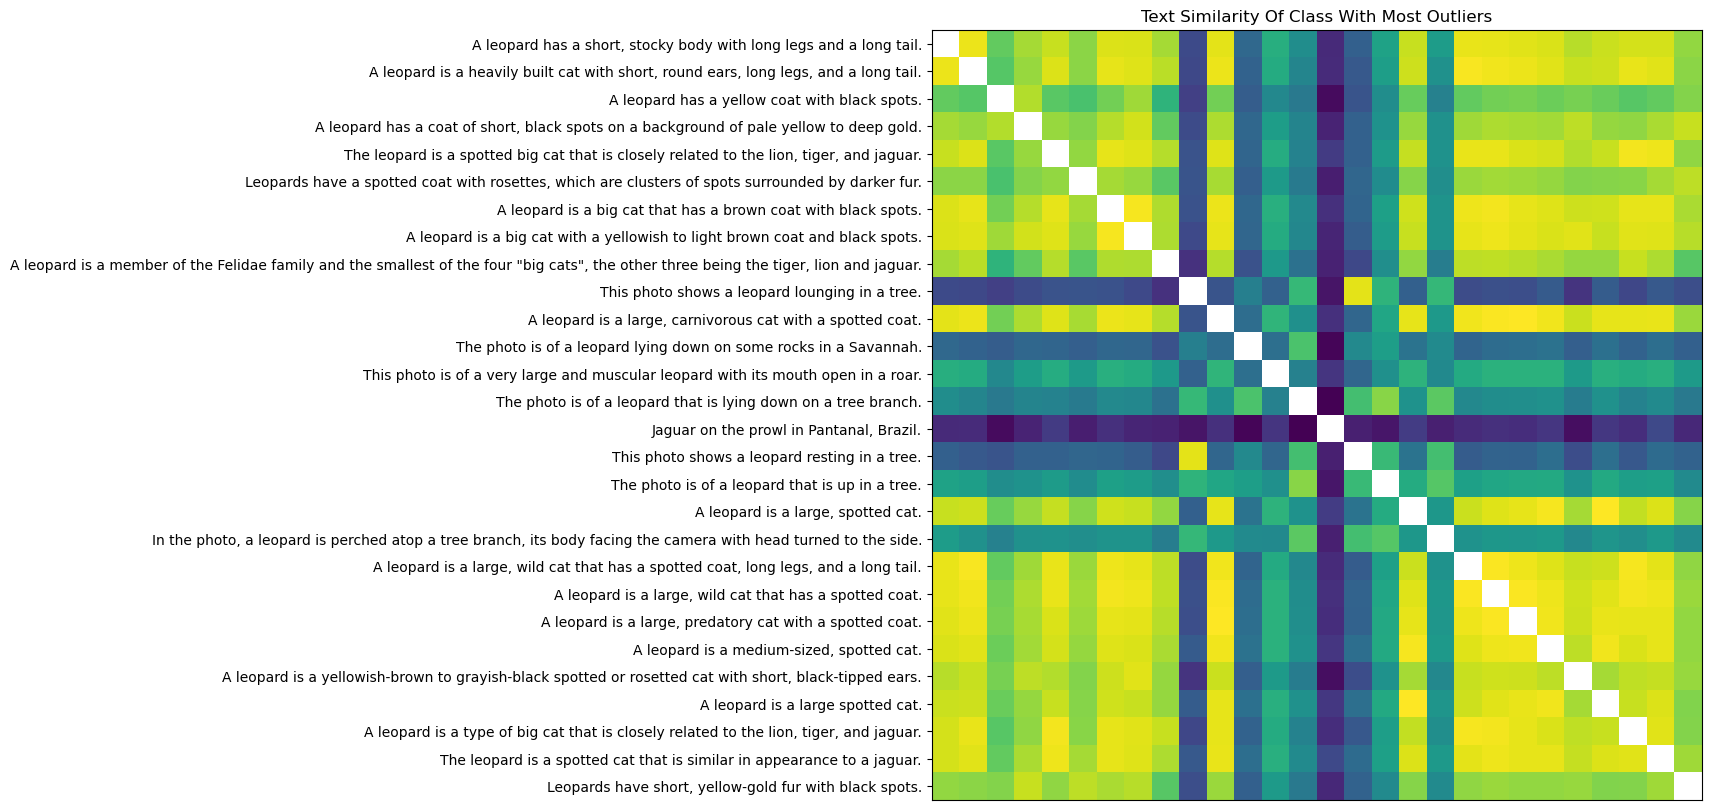

In [17]:
# @title Visualize Dis-similarity Of Outliers In CuPL
print(f'Class: ({top_filtered_label_id}){cls_names_sorted[top_filtered_label_id]}. Filtered {top_filtered_count} outliers:')
ylabels = unique_cupl_prompts[top_filtered_label_id]
for text in outlier_cupl_prompts[top_filtered_label_id]:
    print(f'({ylabels.index(text)}){text}')
plt.figure(figsize=(12, 10))
plt.imshow(unique_cupl_text_similarity[top_filtered_label_id])
plt.xticks([])
plt.yticks(np.arange(0, len(ylabels)), ylabels)
plt.title('Text Similarity Of Class With Most Outliers')
plt.show()

### Text Features Combining 80 Templates And CuPL

In [18]:
# Combine template text with cupl text features
combined_original_cupl_text_features_cuda = [torch.vstack((text_features1, text_features2)) for text_features1, text_features2 in zip(template_text_features_cuda, original_cupl_text_features_cuda)]
combined_filtered_cupl_text_features_cuda = [torch.vstack((text_features1, text_features2)) for text_features1, text_features2 in zip(template_text_features_cuda, filtered_cupl_text_features_cuda)]
combined_original_cupl_cls_features_cuda = []
combined_filtered_cupl_cls_features_cuda = []
for class_embeddings in combined_original_cupl_text_features_cuda:
    class_embedding = class_embeddings.mean(dim=0)
    class_embedding /= class_embedding.norm()
    combined_original_cupl_cls_features_cuda.append(class_embedding)
for class_embeddings in combined_filtered_cupl_text_features_cuda:
    class_embedding = class_embeddings.mean(dim=0)
    class_embedding /= class_embedding.norm()
    combined_filtered_cupl_cls_features_cuda.append(class_embedding)
combined_original_cupl_cls_features_cuda = torch.vstack(combined_original_cupl_cls_features_cuda)
combined_filtered_cupl_cls_features_cuda = torch.vstack(combined_filtered_cupl_cls_features_cuda)

## Calculate Image Features

In [19]:
def encode_images(imgs):
    with torch.no_grad():
        return model.encode_image(torch.stack(imgs).to(device))

In [20]:
# Create image features
imgs_grouped = defaultdict(list)
for img, label_id in dataset_test:
    imgs_grouped[label_id].append(img)
img_label_ids, _, img_features_cuda, _, img_masked_similarity = calc_features(encode_images, imgs_grouped)

100%|██████████| 100/100 [00:03<00:00, 28.60it/s]


# **CLIP Zero-shot Predictions**

## Predictions Using Average Of Text Features

### Calculations

In [21]:
def calc_clip_pred(label_ids, img_features_cuda, text_features_cuda):
    with torch.no_grad():
        if type(text_features_cuda) == list:  # list of tensors
            logits = torch.vstack([(img_features_cuda @ embeddings.T).mean(dim=-1) for embeddings in text_features_cuda]).T
        else:
            logits = img_features_cuda @ text_features_cuda.T
        pred = logits.argmax(dim=-1).cpu().numpy()

        return (pred == label_ids).mean(), sklearn.metrics.confusion_matrix(label_ids, pred, labels=np.arange(len(cls_names_sorted)), normalize='true')

In [22]:
# Zero-shot classification of CLIP
img_features_stacked_cuda = torch.vstack(img_features_cuda)

cls_name_acc, cls_name_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, cls_name_features_cuda)
template_cls_acc, template_cls_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, template_cls_features_cuda)
template_text_acc, template_text_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, template_text_features_cuda)
original_cupl_cls_acc, original_cupl_cls_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, original_cupl_cls_features_cuda)
original_cupl_text_acc, original_cupl_text_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, original_cupl_text_features_cuda)
filtered_cupl_cls_acc, filtered_cupl_cls_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, filtered_cupl_cls_features_cuda)
filtered_cupl_text_acc, filtered_cupl_text_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, filtered_cupl_text_features_cuda)
combined_original_cupl_cls_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_original_cupl_cls_features_cuda)
combined_original_cupl_text_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_original_cupl_text_features_cuda)
combined_filtered_cupl_cls_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_filtered_cupl_cls_features_cuda)
combined_filtered_cupl_text_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_filtered_cupl_text_features_cuda)

In [23]:
# Zero-shot classification of CLIP using one text on all images
template_text_individual_features_cuda = list(torch.stack(template_text_features_cuda).permute(1, 0, 2))
template_text_individual_acc = np.array([calc_clip_pred(img_label_ids, img_features_stacked_cuda, text_features_cuda)[0] for text_features_cuda in template_text_individual_features_cuda])
original_cupl_text_individual_features_cuda = list(torch.stack(original_cupl_text_features_cuda).permute(1, 0, 2))
original_cupl_text_individual_acc = np.array([calc_clip_pred(img_label_ids, img_features_stacked_cuda, text_features_cuda)[0] for text_features_cuda in original_cupl_text_individual_features_cuda])

### Results

In [24]:
# @title Predictions Using Average Of Text Features
print(f'Accuracy of CLIP with class names: {cls_name_acc*100:.2f}%')
print(f'Accuracy of CLIP with text template (centroid): {template_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with text template (individual avg): {template_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with original CuPL text (centroid): {original_cupl_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with original CuPL text (individual avg): {original_cupl_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with filtered CuPL text (centroid): {filtered_cupl_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with filtered CuPL text (individual avg): {filtered_cupl_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined original CuPL text (centroid): {combined_original_cupl_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined original CuPL text (individual avg): {combined_original_cupl_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined filtered CuPL text (centroid): {combined_filtered_cupl_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined filtered CuPL text (individual avg): {combined_filtered_cupl_text_acc*100:.2f}%')

Accuracy of CLIP with class names: 87.14%
Accuracy of CLIP with text template (centroid): 93.10%
Accuracy of CLIP with text template (individual avg): 92.94%
Accuracy of CLIP with original CuPL text (centroid): 94.28%
Accuracy of CLIP with original CuPL text (individual avg): 94.16%
Accuracy of CLIP with filtered CuPL text (centroid): 94.44%
Accuracy of CLIP with filtered CuPL text (individual avg): 94.65%
Accuracy of CLIP with combined original CuPL text (centroid): 94.00%
Accuracy of CLIP with combined original CuPL text (individual avg): 93.87%
Accuracy of CLIP with combined filtered CuPL text (centroid): 93.96%
Accuracy of CLIP with combined filtered CuPL text (individual avg): 93.79%


In [25]:
# @title Predictions Using Individual Text Features Directly
print(f'Accuracy of CLIP with text template (one text on all images): mean={template_text_individual_acc.mean()*100:.2f}%, std={template_text_individual_acc.std()}')
print(f'Accuracy of CLIP with original CuPL text (one text on all images): mean={original_cupl_text_individual_acc.mean()*100:.2f}%, std={original_cupl_text_individual_acc.std()}')

Accuracy of CLIP with text template (one text on all images): mean=90.45%, std=0.023761506019523548
Accuracy of CLIP with original CuPL text (one text on all images): mean=87.89%, std=0.040901365970246344


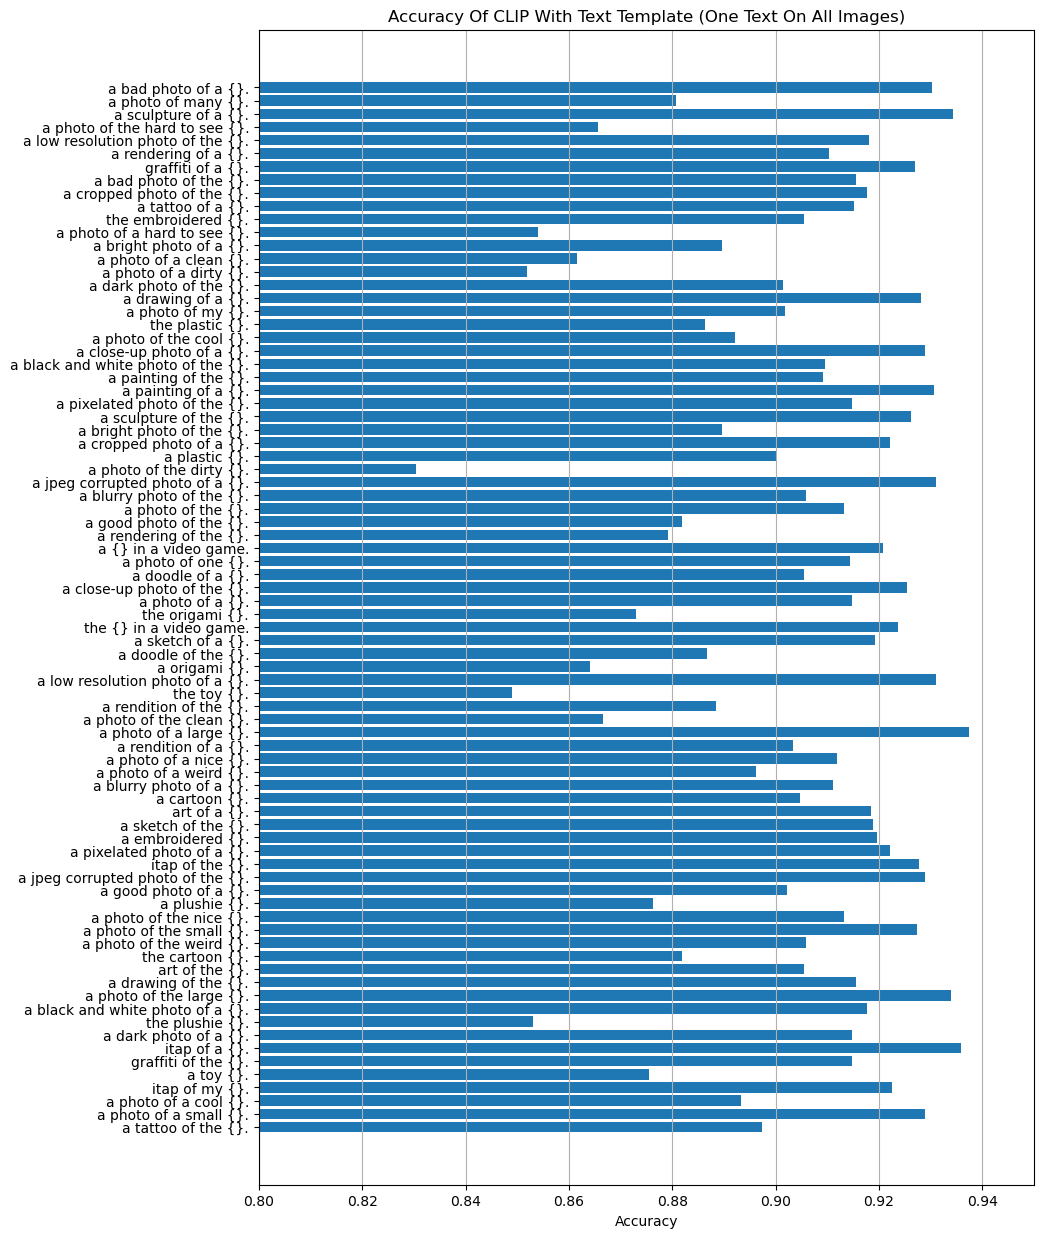

In [26]:
# @title Test Accuracy of Individual 80 Templates
plt.figure(figsize=(10, 15))
plt.barh(np.arange(len(template_text_individual_acc)), template_text_individual_acc, align='center')
plt.yticks(np.arange(len(template_text_individual_acc)), imagenet_templates)
plt.xlabel('Accuracy')
plt.title('Accuracy Of CLIP With Text Template (One Text On All Images)')
scale = 0.05
plt.xlim(int(template_text_individual_acc.min()/scale)*scale, (int(template_text_individual_acc.max()/scale)+1)*scale)
plt.grid(axis='x')
plt.gca().invert_yaxis()
plt.show()

# **Analyze Feature Similarity**

## Similarity Of Classes On Different Text Type

### Define the Functions

In [27]:
def print_top_pairs(similarity, text, *, top=10, xlabel='', ylabel='', coordinates=None):
    # Get the indices of top values
    top_indices = np.unravel_index(np.argsort(-similarity, axis=None)[:top], similarity.shape)

    # Extract the class names and labels for top values
    for idx, (label1, label2) in enumerate(zip(*top_indices)):
        if coordinates is None:
            print(f'Rank {idx+1}: ({label1}){ylabel}{cls_names_sorted[label1]} - ({label2}){xlabel}{cls_names_sorted[label2]}, {text}: {similarity[label1, label2]}')
        else:
            print(f'Rank {idx+1}: ({label1}){ylabel}{cls_names_sorted[label1]}(coor={coordinates[label1][0]:.0f},{coordinates[label1][1]:.0f}) - ({label2}){xlabel}{cls_names_sorted[label2]}(coor={coordinates[label1][0]:.0f},{coordinates[label1][1]:.0f}), {text}: {similarity[label1, label2]}')

In [28]:
def plot_similarity(similarity, title, xlabel=None, ylabel=None):
    plt.figure(figsize=(12, 10))
    plt.imshow(similarity)
    plt.xticks(np.arange(0, similarity.shape[0], 5))
    plt.yticks(np.arange(0, similarity.shape[1], 5))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    plt.title(title)
    plt.show()

In [29]:
def visualize_auto_similarity(masked_similarity, title):
    title_similarity = title + ' Similarity'
    print(f'{title_similarity.capitalize()} mean: {np.nanmean(masked_similarity)}')
    print(f'{title_similarity.capitalize()} std: {np.nanstd(masked_similarity)}')
    print_top_pairs(np.triu(masked_similarity, k=1), 'similarity')
    plot_similarity(masked_similarity, title_similarity)

### Visualizations

Class name similarity mean: 0.69970703125
Class name similarity std: 0.07928466796875
Rank 1: (27)crocodile - (28)crocodile_head, similarity: 0.94677734375
Rank 2: (23)cougar_body - (24)cougar_face, similarity: 0.923828125
Rank 3: (40)flamingo - (41)flamingo_head, similarity: 0.90966796875
Rank 4: (25)crab - (26)crayfish, similarity: 0.8984375
Rank 5: (0)face - (12)brain, similarity: 0.89208984375
Rank 6: (21)chair - (95)wheelchair, similarity: 0.89013671875
Rank 7: (0)face - (24)cougar_face, similarity: 0.89013671875
Rank 8: (25)crab - (58)lobster, similarity: 0.8837890625
Rank 9: (15)butterfly - (33)dragonfly, similarity: 0.8818359375
Rank 10: (26)crayfish - (58)lobster, similarity: 0.8798828125


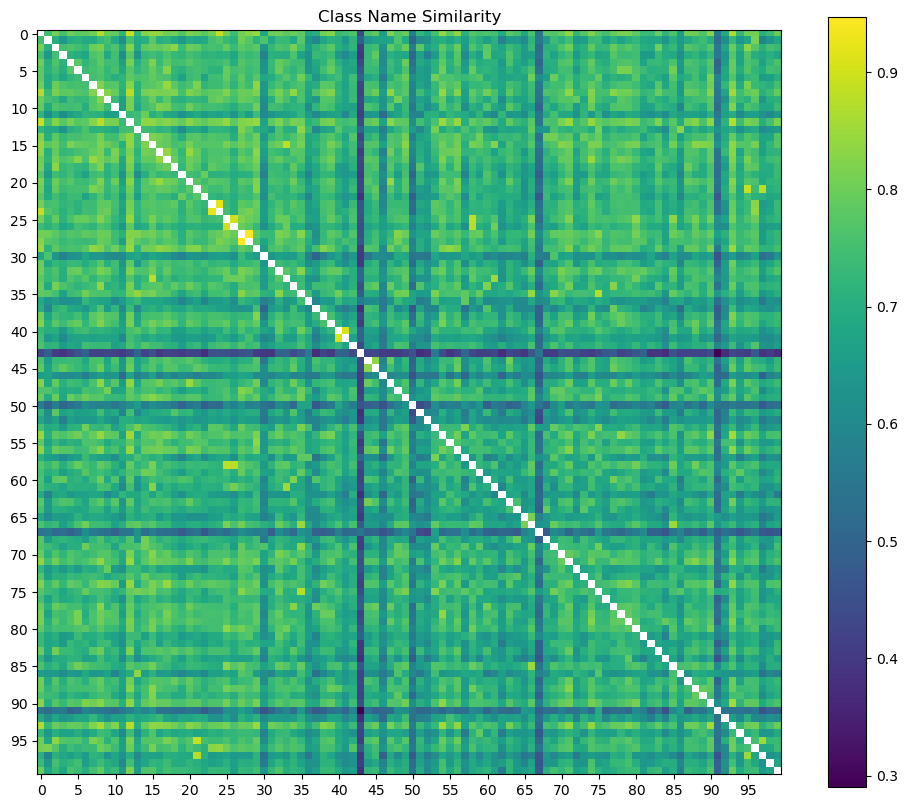

In [30]:
# @title Similarity Of Classes (Class Name)
visualize_auto_similarity(cls_name_masked_similarity, 'Class Name')

Text template similarity mean: 0.69482421875
Text template similarity std: 0.08038330078125
Rank 1: (27)crocodile - (28)crocodile_head, similarity: 0.955078125
Rank 2: (40)flamingo - (41)flamingo_head, similarity: 0.9287109375
Rank 3: (23)cougar_body - (24)cougar_face, similarity: 0.91748046875
Rank 4: (26)crayfish - (58)lobster, similarity: 0.89990234375
Rank 5: (25)crab - (26)crayfish, similarity: 0.89453125
Rank 6: (25)crab - (58)lobster, similarity: 0.89453125
Rank 7: (16)camera - (20)cellphone, similarity: 0.890625
Rank 8: (4)airplane - (49)helicopter, similarity: 0.890625
Rank 9: (21)chair - (95)wheelchair, similarity: 0.888671875
Rank 10: (0)face - (12)brain, similarity: 0.88818359375


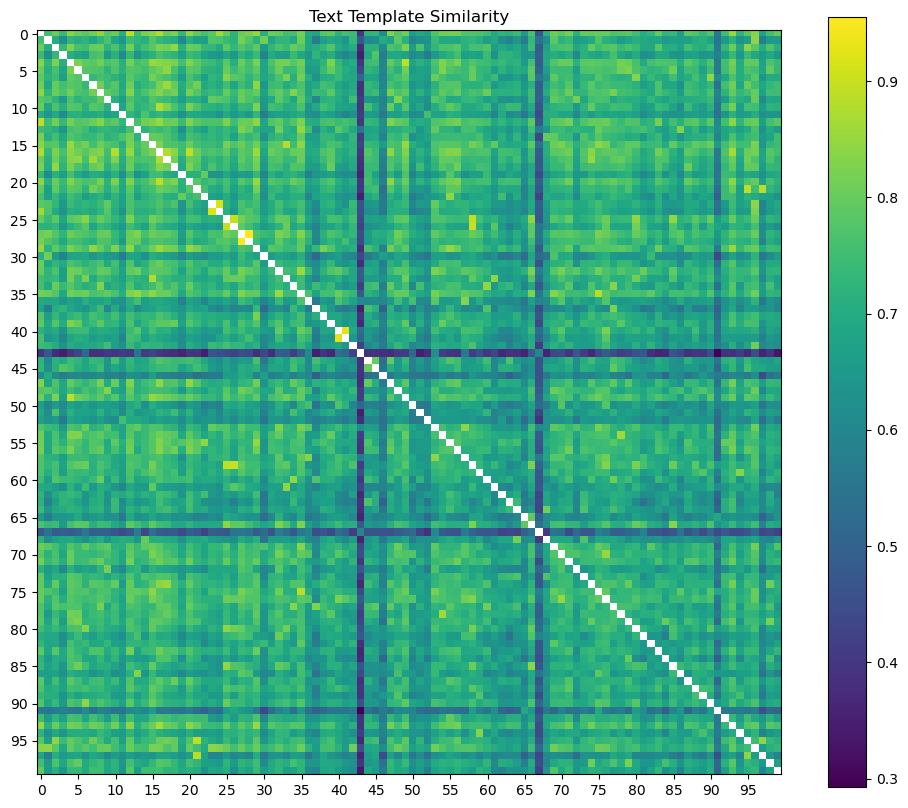

In [31]:
# @title Similarity Of Classes (80 Templates)
visualize_auto_similarity(template_masked_similarity, 'Text Template')

Original cupl text similarity mean: 0.6708984375
Original cupl text similarity std: 0.088134765625
Rank 1: (27)crocodile - (28)crocodile_head, similarity: 0.9716796875
Rank 2: (23)cougar_body - (24)cougar_face, similarity: 0.96142578125
Rank 3: (40)flamingo - (41)flamingo_head, similarity: 0.9169921875
Rank 4: (54)ketch - (78)schooner, similarity: 0.9150390625
Rank 5: (26)crayfish - (58)lobster, similarity: 0.9111328125
Rank 6: (23)cougar_body - (96)wild_cat, similarity: 0.908203125
Rank 7: (25)crab - (58)lobster, similarity: 0.90576171875
Rank 8: (24)cougar_face - (96)wild_cat, similarity: 0.89990234375
Rank 9: (59)lotus - (94)water_lilly, similarity: 0.8984375
Rank 10: (35)elephant - (75)rhino, similarity: 0.89794921875


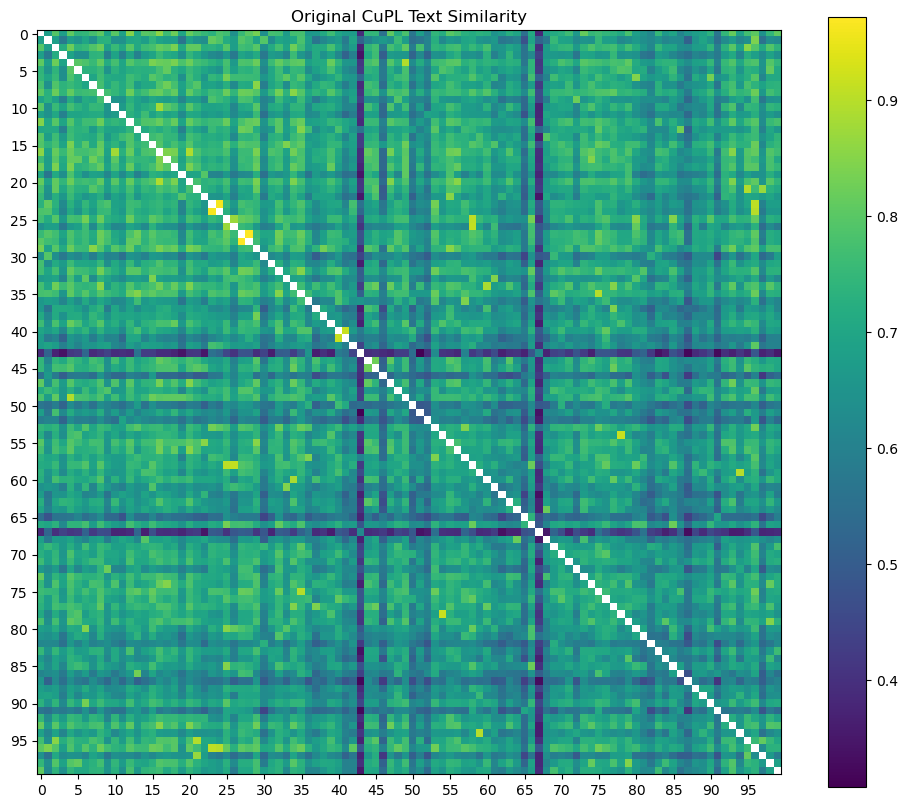

In [32]:
# @title Similarity Of Classes (Original CuPL)
visualize_auto_similarity(original_cupl_masked_similarity, 'Original CuPL Text')

Filtered cupl text similarity mean: 0.66943359375
Filtered cupl text similarity std: 0.08953857421875
Rank 1: (27)crocodile - (28)crocodile_head, similarity: 0.9716796875
Rank 2: (23)cougar_body - (24)cougar_face, similarity: 0.9619140625
Rank 3: (40)flamingo - (41)flamingo_head, similarity: 0.91748046875
Rank 4: (54)ketch - (78)schooner, similarity: 0.91357421875
Rank 5: (26)crayfish - (58)lobster, similarity: 0.91357421875
Rank 6: (25)crab - (58)lobster, similarity: 0.90771484375
Rank 7: (23)cougar_body - (96)wild_cat, similarity: 0.90771484375
Rank 8: (35)elephant - (75)rhino, similarity: 0.89990234375
Rank 9: (59)lotus - (94)water_lilly, similarity: 0.89794921875
Rank 10: (24)cougar_face - (96)wild_cat, similarity: 0.89794921875


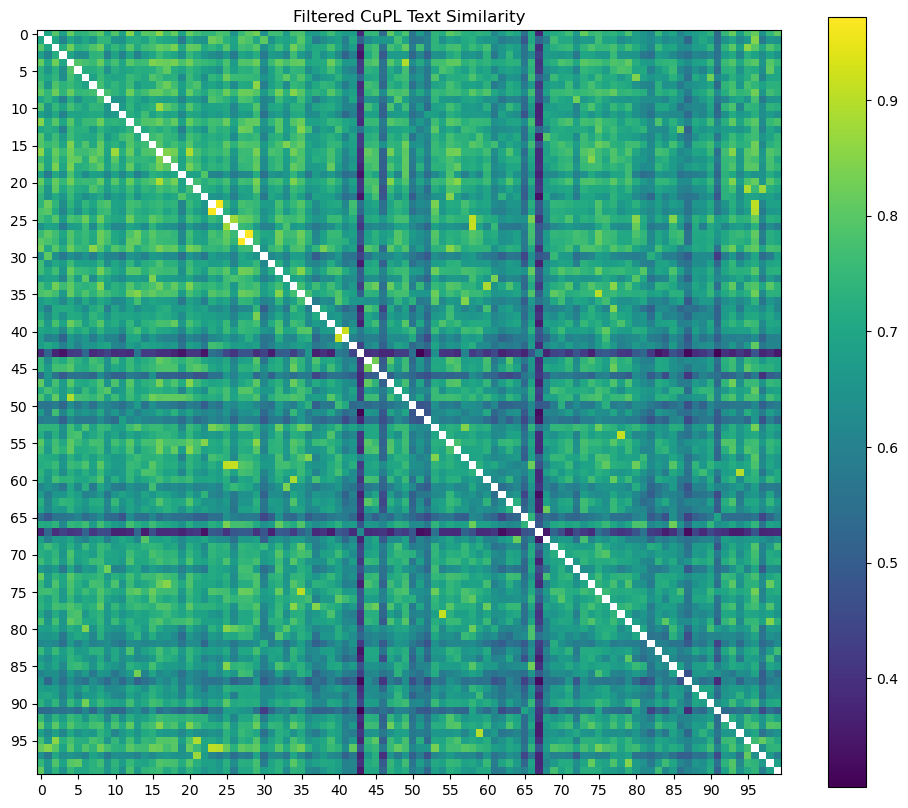

In [33]:
# @title Similarity Of Classes (Filtered CuPL)
visualize_auto_similarity(filtered_cupl_masked_similarity, 'Filtered CuPL Text')

## Similarity Of Classes Between Image And Text

### Define The Functions

In [34]:
def calc_features_similarity(features1_cuda, features2_cuda):
    with torch.no_grad():
        similarity_cuda = []
        for embeddings1 in features1_cuda:
            if type(features2_cuda) == list:  # list of tensors
                similarity_cuda.append(torch.Tensor([(embeddings1 @ embeddings2.T).mean() for embeddings2 in features2_cuda]))
            else:
                similarity_cuda.append((embeddings1 @ features2_cuda.T).mean(dim=0))

        return torch.vstack(similarity_cuda).cpu().numpy()

In [35]:
def plot_cm(cm, title):
    plt.figure(figsize=(12, 10))
    plt.imshow(cm)
    plt.xticks(np.arange(0, cm.shape[0], 5))
    plt.yticks(np.arange(0, cm.shape[1], 5))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

In [36]:
def visualize_cross_similarity(similarity, cm, title, xlabel='Text', ylabel='Image'):
    title_similarity = title + ' Similarity'
    print(f'{title_similarity.capitalize()} mean: {np.mean(similarity)}')
    print(f'{title_similarity.capitalize()} std: {np.std(similarity)}')
    diagonal_similarity = similarity.diagonal()
    print(f'{title_similarity.capitalize()} diagonal mean: {np.mean(diagonal_similarity)}')
    print(f'{title_similarity.capitalize()} diagonal std: {np.std(diagonal_similarity)}')
    masked_similarity = similarity.copy()
    np.fill_diagonal(masked_similarity, np.nan)
    print(f'{title_similarity.capitalize()} non-diagonal mean: {np.nanmean(masked_similarity)}')
    print(f'{title_similarity.capitalize()} non-diagonal std: {np.nanstd(masked_similarity)}')
    print(f'{title_similarity.capitalize()} diagonal mean to non-diagonal mean ratio: {np.mean(diagonal_similarity)/np.nanmean(masked_similarity)}')
    print_top_pairs(masked_similarity, 'similarity', top=20, xlabel=f'({xlabel})', ylabel=f'({ylabel})')
    plot_similarity(similarity, title_similarity, xlabel=xlabel, ylabel=ylabel)
    masked_cm = cm.copy()
    np.fill_diagonal(masked_cm, np.nan)
    print_top_pairs(masked_cm, 'error rate', top=20, xlabel=f'({xlabel})', ylabel=f'({ylabel})')
    plot_cm(cm, title + ' Confusion Matrix')

### Visualizations

Image similarity mean: 0.7080078125
Image similarity std: 0.06591796875
Rank 1: (59)lotus - (94)water_lilly, similarity: 0.9833984375
Rank 2: (54)ketch - (78)schooner, similarity: 0.97509765625
Rank 3: (27)crocodile - (28)crocodile_head, similarity: 0.96826171875
Rank 4: (21)chair - (97)windsor_chair, similarity: 0.96630859375
Rank 5: (26)crayfish - (58)lobster, similarity: 0.96240234375
Rank 6: (23)cougar_body - (24)cougar_face, similarity: 0.96044921875
Rank 7: (40)flamingo - (41)flamingo_head, similarity: 0.95751953125
Rank 8: (26)crayfish - (80)scorpion, similarity: 0.95556640625
Rank 9: (25)crab - (26)crayfish, similarity: 0.94873046875
Rank 10: (33)dragonfly - (61)mayfly, similarity: 0.94873046875


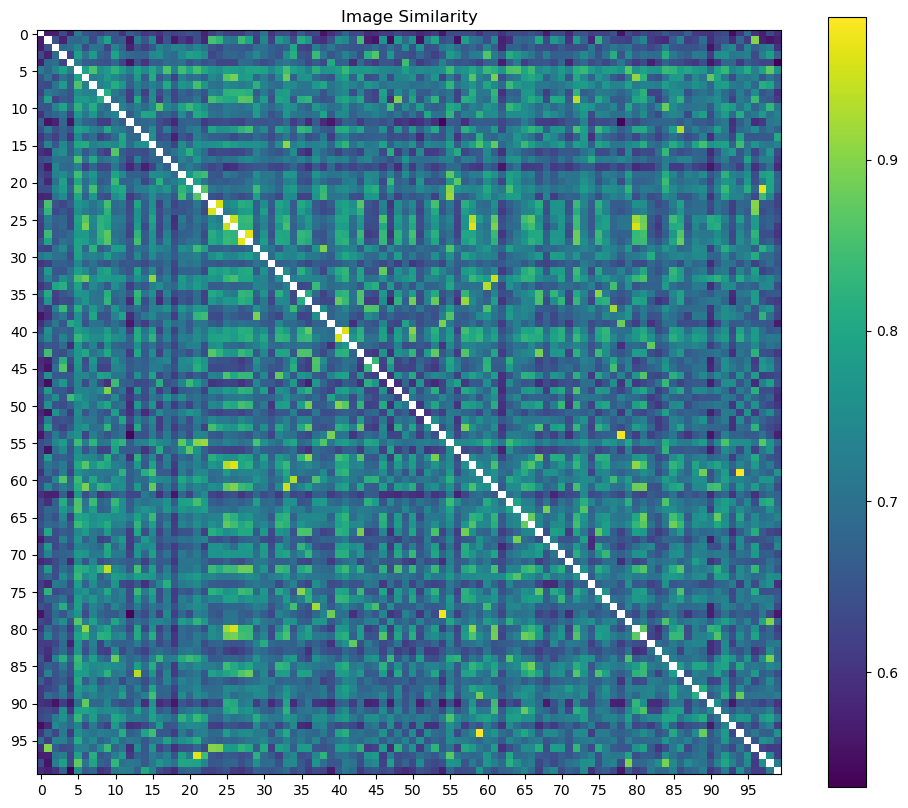

In [37]:
# @title Similarity Of Classes (Image)
visualize_auto_similarity(img_masked_similarity, 'Image')

Image to class name similarity mean: 0.1925048828125
Image to class name similarity std: 0.0236358642578125
Image to class name similarity diagonal mean: 0.298583984375
Image to class name similarity diagonal std: 0.0182037353515625
Image to class name similarity non-diagonal mean: 0.19140625
Image to class name similarity non-diagonal std: 0.0211029052734375
Image to class name similarity diagonal mean to non-diagonal mean ratio: 1.5595703125
Rank 1: (40)(Image)flamingo - (41)(Text)flamingo_head, similarity: 0.2998046875
Rank 2: (97)(Image)windsor_chair - (21)(Text)chair, similarity: 0.299560546875
Rank 3: (21)(Image)chair - (97)(Text)windsor_chair, similarity: 0.297119140625
Rank 4: (41)(Image)flamingo_head - (40)(Text)flamingo, similarity: 0.29443359375
Rank 5: (59)(Image)lotus - (94)(Text)water_lilly, similarity: 0.2939453125
Rank 6: (28)(Image)crocodile_head - (27)(Text)crocodile, similarity: 0.293701171875
Rank 7: (54)(Image)ketch - (78)(Text)schooner, similarity: 0.293212890625


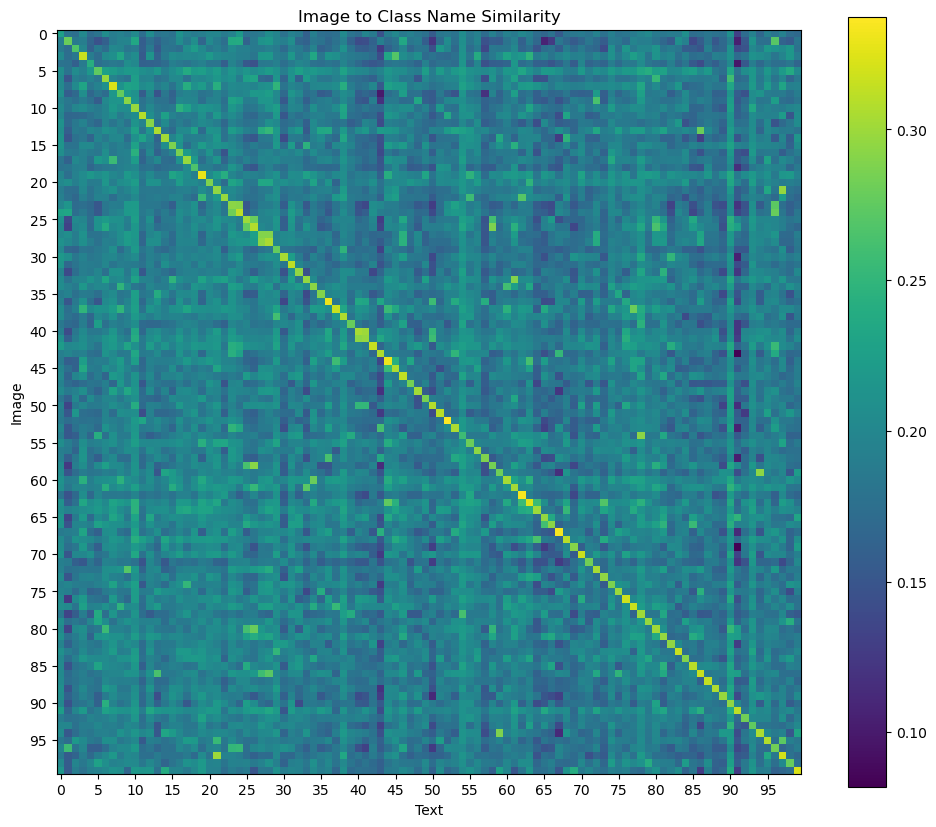

Rank 1: (54)(Image)ketch - (78)(Text)schooner, error rate: 1.0
Rank 2: (59)(Image)lotus - (94)(Text)water_lilly, error rate: 0.75
Rank 3: (21)(Image)chair - (97)(Text)windsor_chair, error rate: 0.5789473684210527
Rank 4: (58)(Image)lobster - (26)(Text)crayfish, error rate: 0.5384615384615384
Rank 5: (27)(Image)crocodile - (28)(Text)crocodile_head, error rate: 0.4666666666666667
Rank 6: (23)(Image)cougar_body - (24)(Text)cougar_face, error rate: 0.42857142857142855
Rank 7: (41)(Image)flamingo_head - (40)(Text)flamingo, error rate: 0.42857142857142855
Rank 8: (40)(Image)flamingo - (41)(Text)flamingo_head, error rate: 0.35
Rank 9: (33)(Image)dragonfly - (61)(Text)mayfly, error rate: 0.3
Rank 10: (0)(Image)face - (6)(Text)ant, error rate: 0.23846153846153847
Rank 11: (0)(Image)face - (24)(Text)cougar_face, error rate: 0.18461538461538463
Rank 12: (98)(Image)wrench - (79)(Text)scissors, error rate: 0.18181818181818182
Rank 13: (60)(Image)mandolin - (34)(Text)electric_guitar, error rate: 0.1

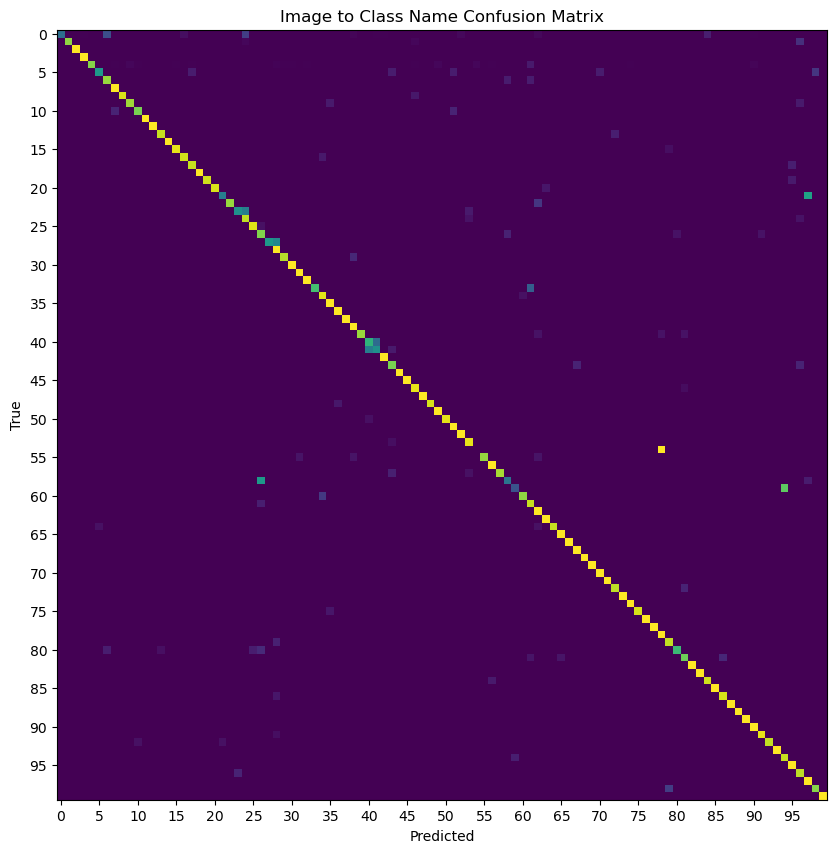

In [38]:
# @title Similarity Of Classes (Image vs Class Name)
visualize_cross_similarity(calc_features_similarity(img_features_cuda, cls_name_features_cuda), cls_name_cm, 'Image to Class Name')

Image to text template (centroid) similarity mean: 0.1964111328125
Image to text template (centroid) similarity std: 0.0265045166015625
Image to text template (centroid) similarity diagonal mean: 0.322998046875
Image to text template (centroid) similarity diagonal std: 0.018768310546875
Image to text template (centroid) similarity non-diagonal mean: 0.1951904296875
Image to text template (centroid) similarity non-diagonal std: 0.0233001708984375
Image to text template (centroid) similarity diagonal mean to non-diagonal mean ratio: 1.654296875
Rank 1: (78)(Image)schooner - (54)(Text)ketch, similarity: 0.323486328125
Rank 2: (41)(Image)flamingo_head - (40)(Text)flamingo, similarity: 0.3232421875
Rank 3: (24)(Image)cougar_face - (23)(Text)cougar_body, similarity: 0.3212890625
Rank 4: (28)(Image)crocodile_head - (27)(Text)crocodile, similarity: 0.3203125
Rank 5: (40)(Image)flamingo - (41)(Text)flamingo_head, similarity: 0.31884765625
Rank 6: (23)(Image)cougar_body - (24)(Text)cougar_face, 

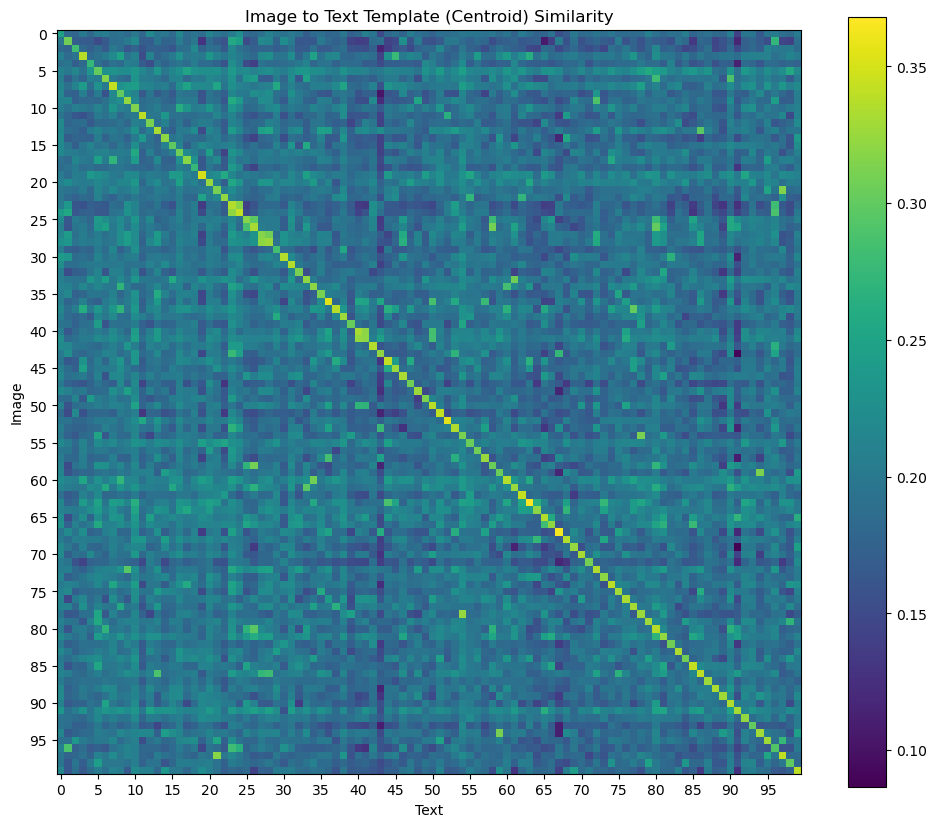

Rank 1: (21)(Image)chair - (97)(Text)windsor_chair, error rate: 0.7368421052631579
Rank 2: (59)(Image)lotus - (94)(Text)water_lilly, error rate: 0.65
Rank 3: (41)(Image)flamingo_head - (40)(Text)flamingo, error rate: 0.5714285714285714
Rank 4: (54)(Image)ketch - (78)(Text)schooner, error rate: 0.5
Rank 5: (96)(Image)wild_cat - (1)(Text)leopard, error rate: 0.5
Rank 6: (58)(Image)lobster - (26)(Text)crayfish, error rate: 0.46153846153846156
Rank 7: (78)(Image)schooner - (54)(Text)ketch, error rate: 0.3333333333333333
Rank 8: (33)(Image)dragonfly - (61)(Text)mayfly, error rate: 0.3
Rank 9: (96)(Image)wild_cat - (23)(Text)cougar_body, error rate: 0.2
Rank 10: (98)(Image)wrench - (79)(Text)scissors, error rate: 0.18181818181818182
Rank 11: (5)(Image)anchor - (98)(Text)wrench, error rate: 0.15384615384615385
Rank 12: (84)(Image)stapler - (51)(Text)inline_skate, error rate: 0.14285714285714285
Rank 13: (9)(Image)beaver - (23)(Text)cougar_body, error rate: 0.14285714285714285
Rank 14: (28)(Im

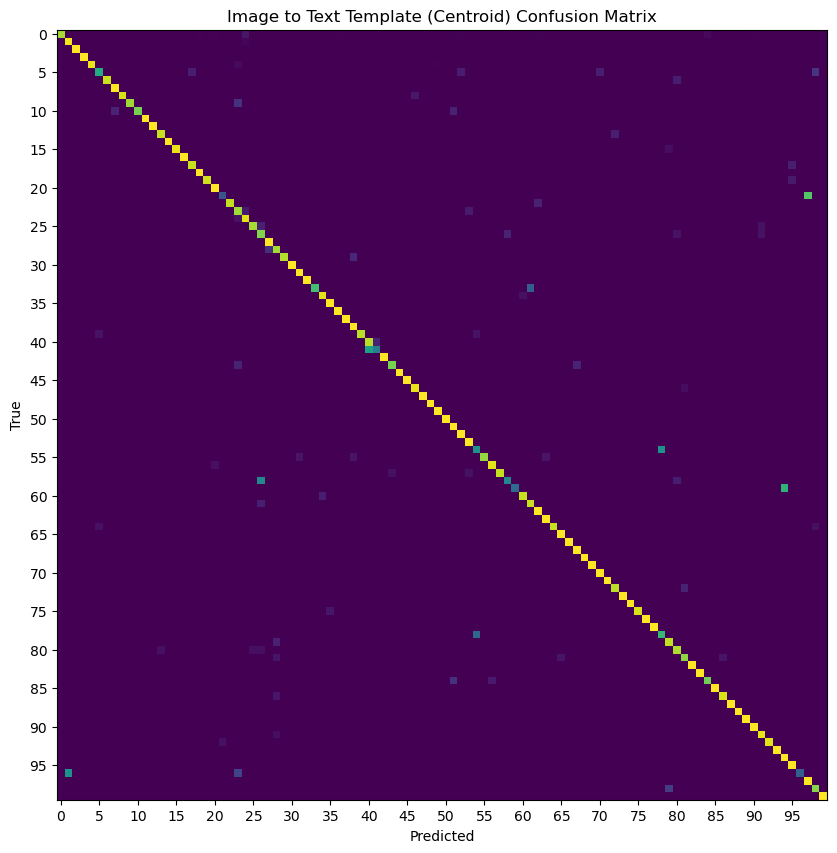

Image to text template (individual avg) similarity mean: 0.17965322732925415
Image to text template (individual avg) similarity std: 0.024276724085211754
Image to text template (individual avg) similarity diagonal mean: 0.29536986351013184
Image to text template (individual avg) similarity diagonal std: 0.01737390272319317
Image to text template (individual avg) similarity non-diagonal mean: 0.17848435044288635
Image to text template (individual avg) similarity non-diagonal std: 0.021345753222703934
Image to text template (individual avg) similarity diagonal mean to non-diagonal mean ratio: 1.6548782587051392
Rank 1: (24)(Image)cougar_face - (23)(Text)cougar_body, similarity: 0.29443359375
Rank 2: (78)(Image)schooner - (54)(Text)ketch, similarity: 0.29443359375
Rank 3: (41)(Image)flamingo_head - (40)(Text)flamingo, similarity: 0.29443359375
Rank 4: (40)(Image)flamingo - (41)(Text)flamingo_head, similarity: 0.29345703125
Rank 5: (28)(Image)crocodile_head - (27)(Text)crocodile, similarit

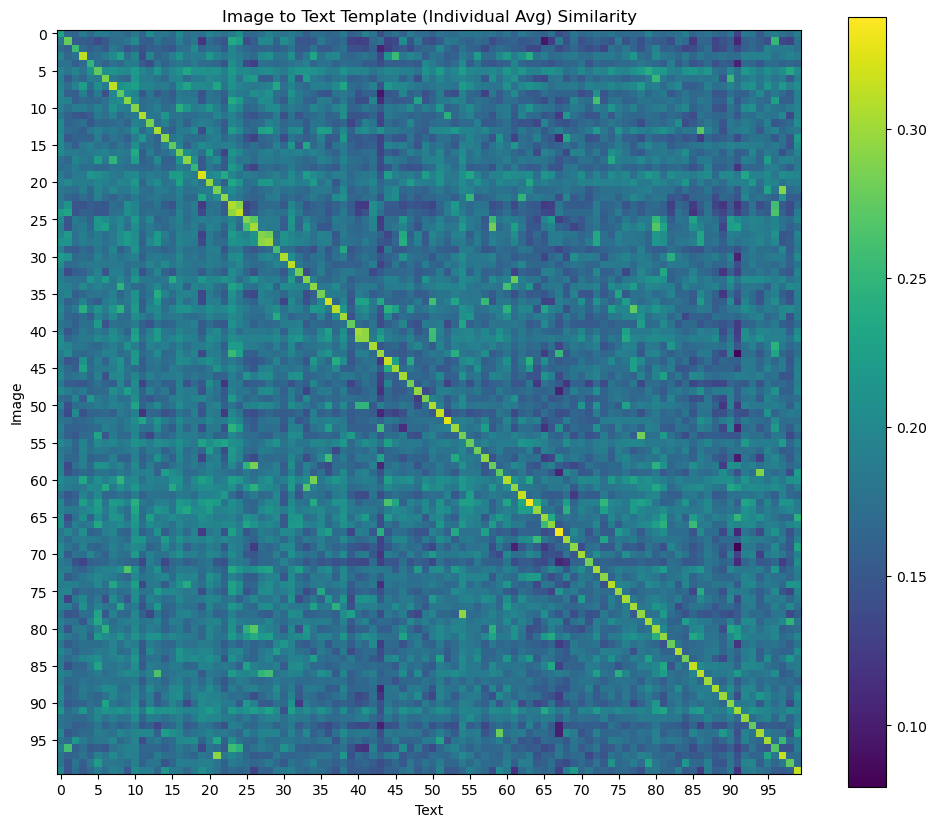

Rank 1: (59)(Image)lotus - (94)(Text)water_lilly, error rate: 0.8
Rank 2: (21)(Image)chair - (97)(Text)windsor_chair, error rate: 0.7368421052631579
Rank 3: (58)(Image)lobster - (26)(Text)crayfish, error rate: 0.5384615384615384
Rank 4: (96)(Image)wild_cat - (1)(Text)leopard, error rate: 0.5
Rank 5: (41)(Image)flamingo_head - (40)(Text)flamingo, error rate: 0.5
Rank 6: (54)(Image)ketch - (78)(Text)schooner, error rate: 0.47058823529411764
Rank 7: (78)(Image)schooner - (54)(Text)ketch, error rate: 0.3888888888888889
Rank 8: (33)(Image)dragonfly - (61)(Text)mayfly, error rate: 0.3
Rank 9: (96)(Image)wild_cat - (23)(Text)cougar_body, error rate: 0.2
Rank 10: (98)(Image)wrench - (79)(Text)scissors, error rate: 0.18181818181818182
Rank 11: (5)(Image)anchor - (98)(Text)wrench, error rate: 0.15384615384615385
Rank 12: (9)(Image)beaver - (23)(Text)cougar_body, error rate: 0.14285714285714285
Rank 13: (84)(Image)stapler - (51)(Text)inline_skate, error rate: 0.14285714285714285
Rank 14: (29)(Ima

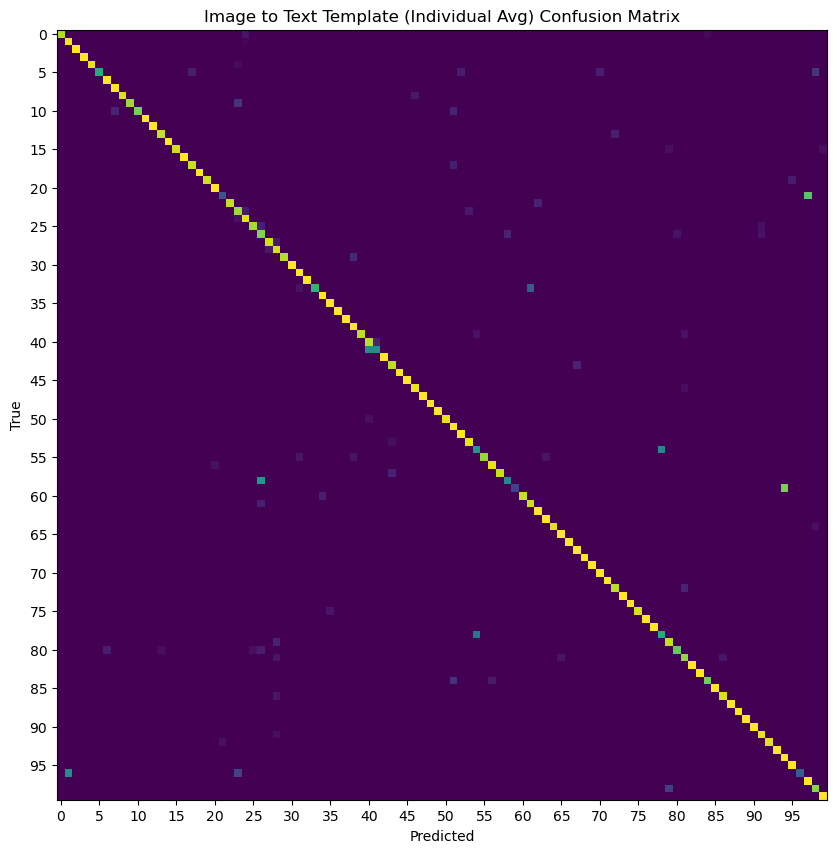

In [39]:
# @title Similarity Of Classes (Image vs 80 Templates)
visualize_cross_similarity(calc_features_similarity(img_features_cuda, template_cls_features_cuda), template_cls_cm, 'Image to Text Template (Centroid)')
visualize_cross_similarity(calc_features_similarity(img_features_cuda, template_text_features_cuda), template_text_cm, 'Image to Text Template (Individual Avg)')

Image to original cupl text (centroid) similarity mean: 0.195556640625
Image to original cupl text (centroid) similarity std: 0.0283050537109375
Image to original cupl text (centroid) similarity diagonal mean: 0.333251953125
Image to original cupl text (centroid) similarity diagonal std: 0.0185546875
Image to original cupl text (centroid) similarity non-diagonal mean: 0.1942138671875
Image to original cupl text (centroid) similarity non-diagonal std: 0.0247650146484375
Image to original cupl text (centroid) similarity diagonal mean to non-diagonal mean ratio: 1.7158203125
Rank 1: (94)(Image)water_lilly - (59)(Text)lotus, similarity: 0.337646484375
Rank 2: (78)(Image)schooner - (54)(Text)ketch, similarity: 0.3349609375
Rank 3: (28)(Image)crocodile_head - (27)(Text)crocodile, similarity: 0.333251953125
Rank 4: (41)(Image)flamingo_head - (40)(Text)flamingo, similarity: 0.332763671875
Rank 5: (40)(Image)flamingo - (41)(Text)flamingo_head, similarity: 0.330322265625
Rank 6: (24)(Image)couga

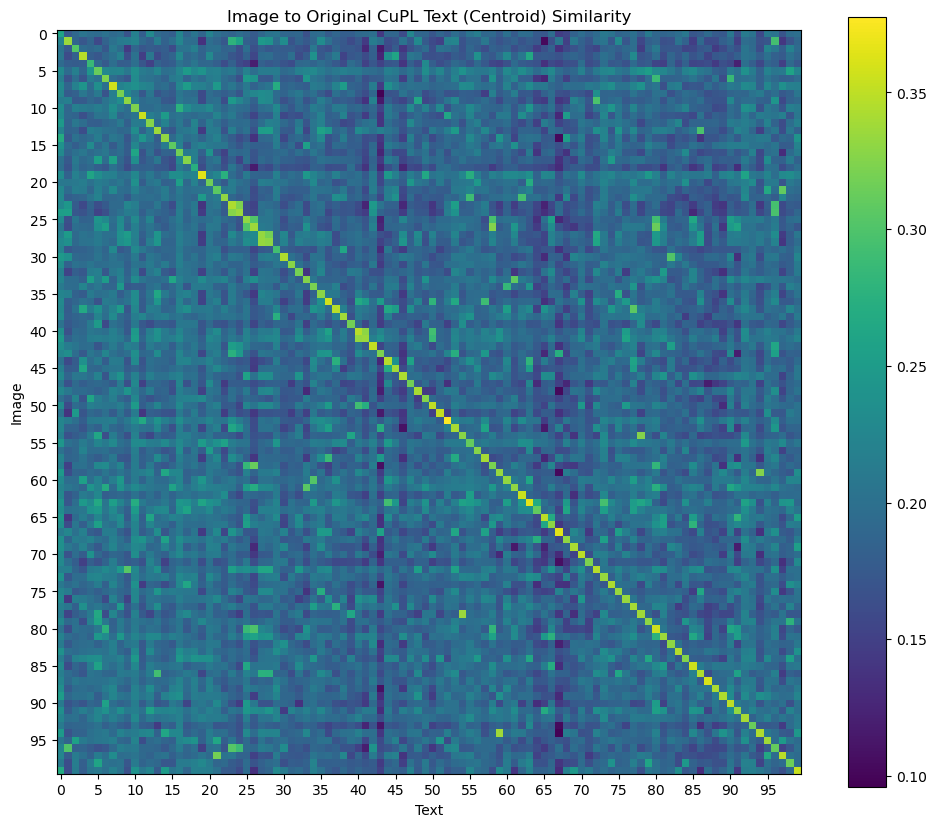

Rank 1: (28)(Image)crocodile_head - (27)(Text)crocodile, error rate: 0.8
Rank 2: (21)(Image)chair - (97)(Text)windsor_chair, error rate: 0.631578947368421
Rank 3: (94)(Image)water_lilly - (59)(Text)lotus, error rate: 0.4166666666666667
Rank 4: (78)(Image)schooner - (54)(Text)ketch, error rate: 0.3888888888888889
Rank 5: (59)(Image)lotus - (94)(Text)water_lilly, error rate: 0.35
Rank 6: (58)(Image)lobster - (26)(Text)crayfish, error rate: 0.3076923076923077
Rank 7: (96)(Image)wild_cat - (23)(Text)cougar_body, error rate: 0.3
Rank 8: (96)(Image)wild_cat - (1)(Text)leopard, error rate: 0.3
Rank 9: (54)(Image)ketch - (78)(Text)schooner, error rate: 0.29411764705882354
Rank 10: (41)(Image)flamingo_head - (40)(Text)flamingo, error rate: 0.2857142857142857
Rank 11: (33)(Image)dragonfly - (61)(Text)mayfly, error rate: 0.25
Rank 12: (26)(Image)crayfish - (58)(Text)lobster, error rate: 0.23809523809523808
Rank 13: (29)(Image)cup - (38)(Text)ewer, error rate: 0.1111111111111111
Rank 14: (43)(Imag

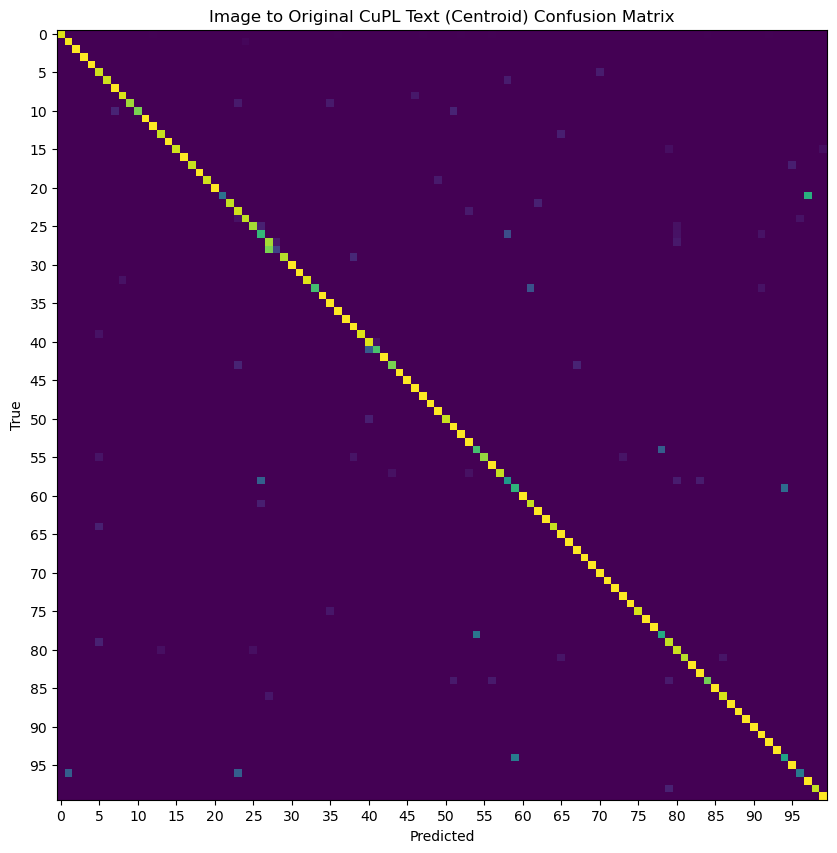

Image to original cupl text (individual avg) similarity mean: 0.18378494679927826
Image to original cupl text (individual avg) similarity std: 0.026468710973858833
Image to original cupl text (individual avg) similarity diagonal mean: 0.3132971227169037
Image to original cupl text (individual avg) similarity diagonal std: 0.019151650369167328
Image to original cupl text (individual avg) similarity non-diagonal mean: 0.18247675895690918
Image to original cupl text (individual avg) similarity non-diagonal std: 0.023082999512553215
Image to original cupl text (individual avg) similarity diagonal mean to non-diagonal mean ratio: 1.716915249824524
Rank 1: (78)(Image)schooner - (54)(Text)ketch, similarity: 0.32080078125
Rank 2: (28)(Image)crocodile_head - (27)(Text)crocodile, similarity: 0.3154296875
Rank 3: (40)(Image)flamingo - (41)(Text)flamingo_head, similarity: 0.31396484375
Rank 4: (41)(Image)flamingo_head - (40)(Text)flamingo, similarity: 0.313232421875
Rank 5: (54)(Image)ketch - (78)

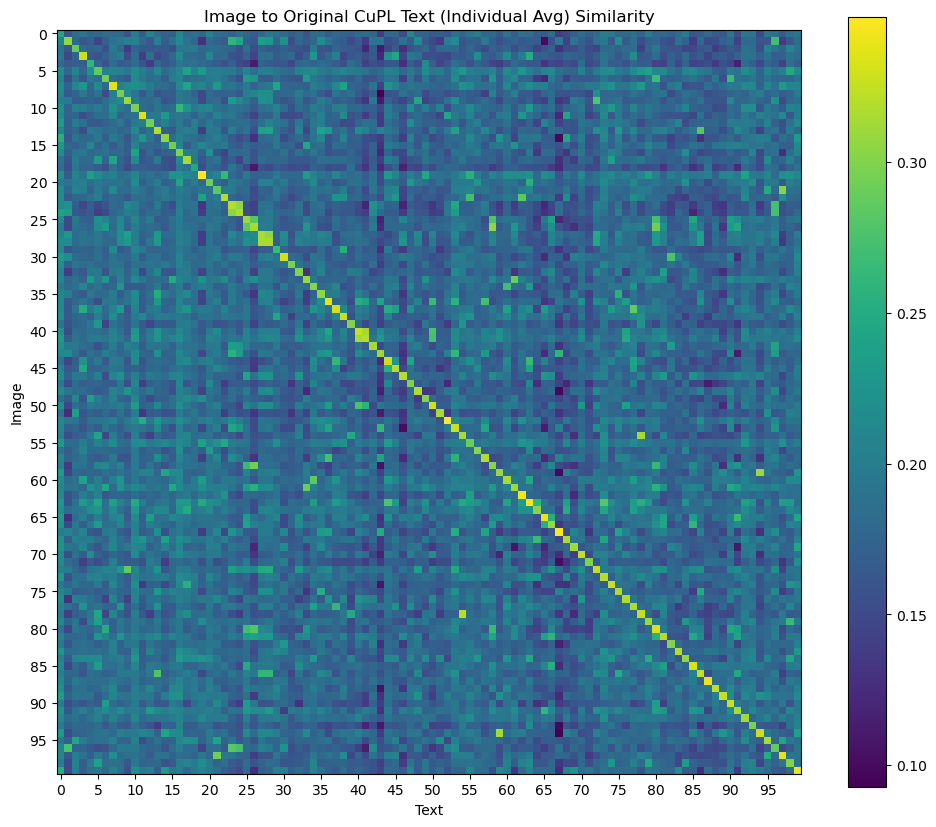

Rank 1: (21)(Image)chair - (97)(Text)windsor_chair, error rate: 0.8947368421052632
Rank 2: (28)(Image)crocodile_head - (27)(Text)crocodile, error rate: 0.4666666666666667
Rank 3: (59)(Image)lotus - (94)(Text)water_lilly, error rate: 0.45
Rank 4: (54)(Image)ketch - (78)(Text)schooner, error rate: 0.4411764705882353
Rank 5: (29)(Image)cup - (38)(Text)ewer, error rate: 0.3333333333333333
Rank 6: (58)(Image)lobster - (26)(Text)crayfish, error rate: 0.3076923076923077
Rank 7: (96)(Image)wild_cat - (1)(Text)leopard, error rate: 0.3
Rank 8: (96)(Image)wild_cat - (23)(Text)cougar_body, error rate: 0.3
Rank 9: (41)(Image)flamingo_head - (40)(Text)flamingo, error rate: 0.2857142857142857
Rank 10: (78)(Image)schooner - (54)(Text)ketch, error rate: 0.2777777777777778
Rank 11: (26)(Image)crayfish - (58)(Text)lobster, error rate: 0.23809523809523808
Rank 12: (33)(Image)dragonfly - (61)(Text)mayfly, error rate: 0.2
Rank 13: (43)(Image)gerenuk - (67)(Text)okapi, error rate: 0.1
Rank 14: (10)(Image)bin

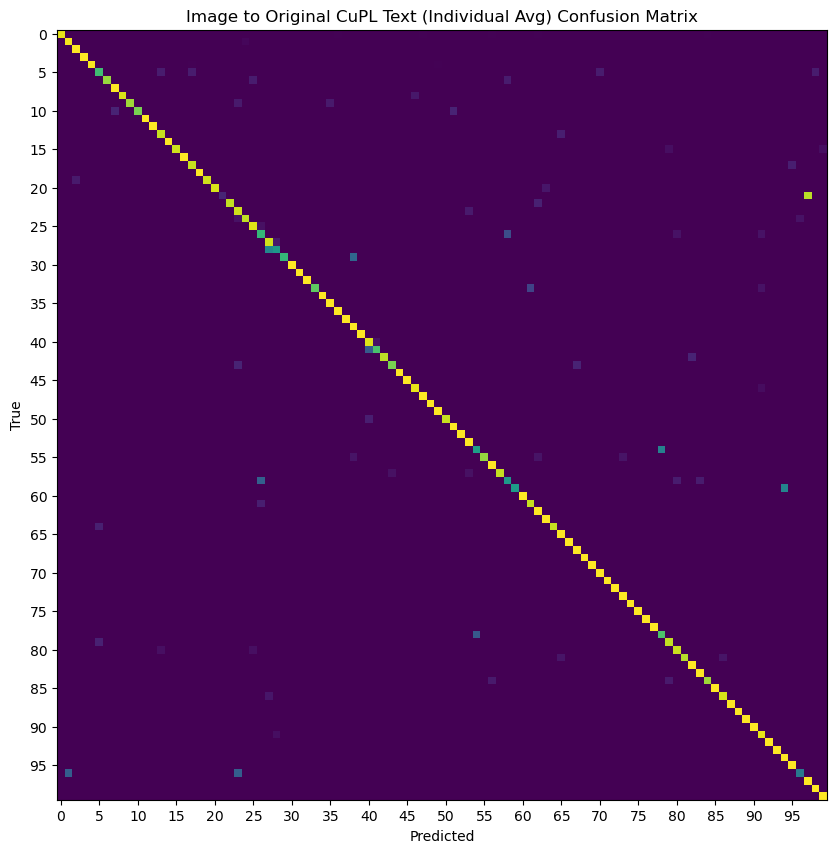

In [40]:
# @title Similarity Of Classes (Image vs Original CuPL)
visualize_cross_similarity(calc_features_similarity(img_features_cuda, original_cupl_cls_features_cuda), original_cupl_cls_cm, 'Image to Original CuPL Text (Centroid)')
visualize_cross_similarity(calc_features_similarity(img_features_cuda, original_cupl_text_features_cuda), original_cupl_text_cm, 'Image to Original CuPL Text (Individual Avg)')

Image to filtered cupl text (centroid) similarity mean: 0.195068359375
Image to filtered cupl text (centroid) similarity std: 0.0283355712890625
Image to filtered cupl text (centroid) similarity diagonal mean: 0.3330078125
Image to filtered cupl text (centroid) similarity diagonal std: 0.0183868408203125
Image to filtered cupl text (centroid) similarity non-diagonal mean: 0.1937255859375
Image to filtered cupl text (centroid) similarity non-diagonal std: 0.0247802734375
Image to filtered cupl text (centroid) similarity diagonal mean to non-diagonal mean ratio: 1.71875
Rank 1: (94)(Image)water_lilly - (59)(Text)lotus, similarity: 0.3349609375
Rank 2: (78)(Image)schooner - (54)(Text)ketch, similarity: 0.33349609375
Rank 3: (28)(Image)crocodile_head - (27)(Text)crocodile, similarity: 0.333251953125
Rank 4: (41)(Image)flamingo_head - (40)(Text)flamingo, similarity: 0.330810546875
Rank 5: (40)(Image)flamingo - (41)(Text)flamingo_head, similarity: 0.330322265625
Rank 6: (54)(Image)ketch - (7

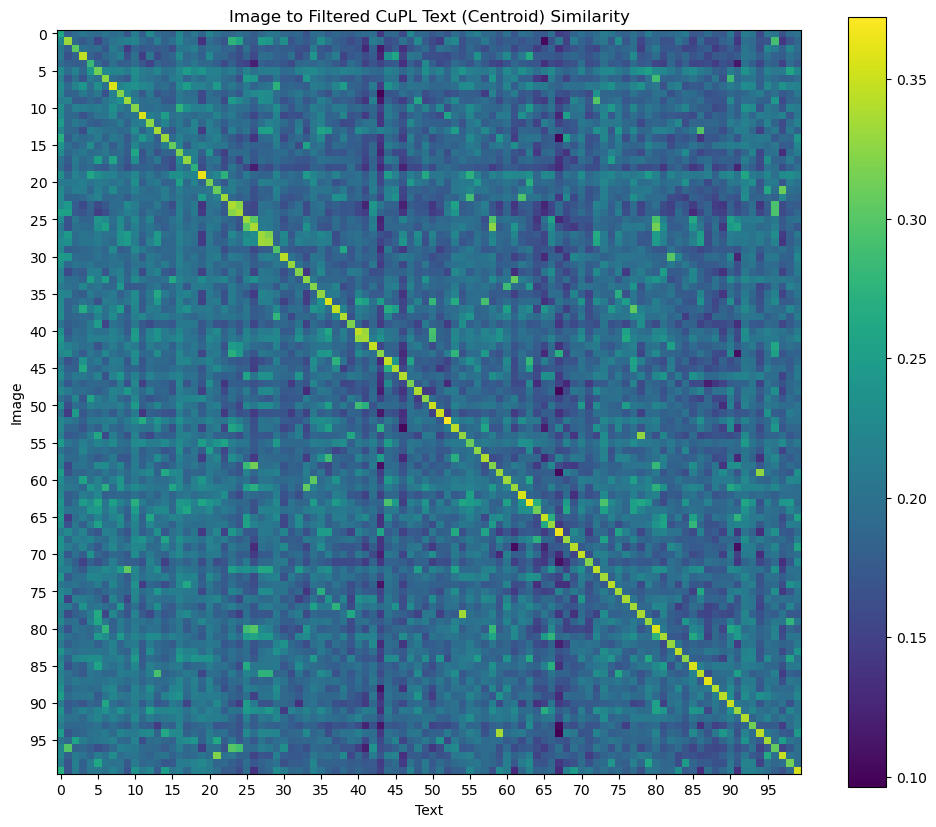

Rank 1: (28)(Image)crocodile_head - (27)(Text)crocodile, error rate: 0.8
Rank 2: (21)(Image)chair - (97)(Text)windsor_chair, error rate: 0.631578947368421
Rank 3: (54)(Image)ketch - (78)(Text)schooner, error rate: 0.47058823529411764
Rank 4: (96)(Image)wild_cat - (1)(Text)leopard, error rate: 0.4
Rank 5: (59)(Image)lotus - (94)(Text)water_lilly, error rate: 0.35
Rank 6: (58)(Image)lobster - (26)(Text)crayfish, error rate: 0.3076923076923077
Rank 7: (41)(Image)flamingo_head - (40)(Text)flamingo, error rate: 0.2857142857142857
Rank 8: (78)(Image)schooner - (54)(Text)ketch, error rate: 0.2777777777777778
Rank 9: (33)(Image)dragonfly - (61)(Text)mayfly, error rate: 0.25
Rank 10: (96)(Image)wild_cat - (23)(Text)cougar_body, error rate: 0.2
Rank 11: (26)(Image)crayfish - (58)(Text)lobster, error rate: 0.19047619047619047
Rank 12: (29)(Image)cup - (38)(Text)ewer, error rate: 0.1111111111111111
Rank 13: (43)(Image)gerenuk - (67)(Text)okapi, error rate: 0.1
Rank 14: (10)(Image)binocular - (51)(

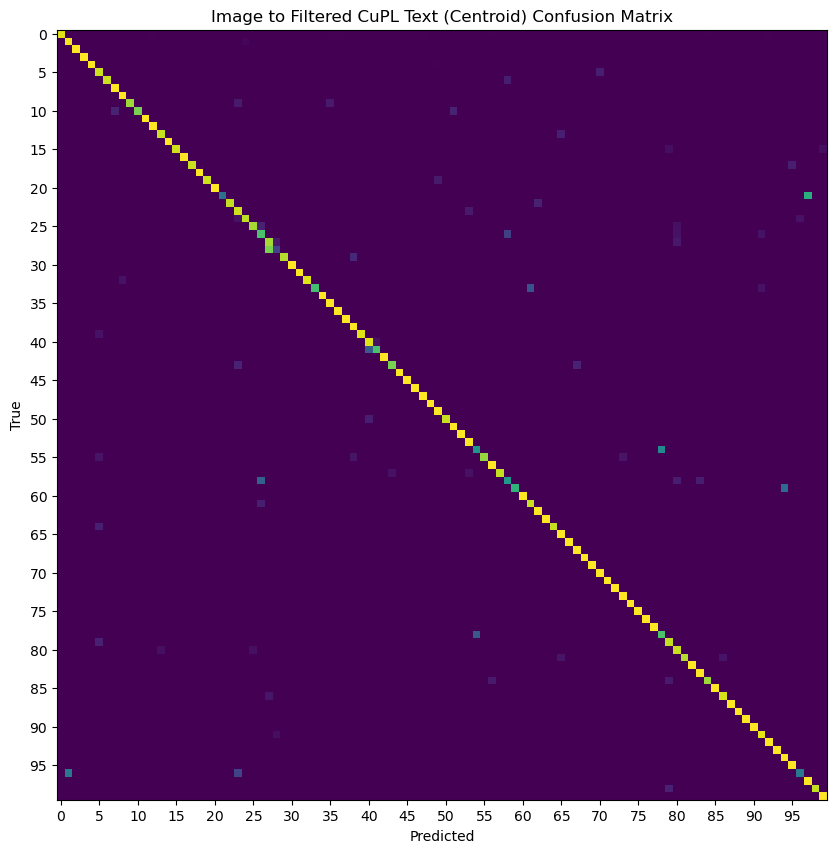

Image to filtered cupl text (individual avg) similarity mean: 0.18412405252456665
Image to filtered cupl text (individual avg) similarity std: 0.02662849798798561
Image to filtered cupl text (individual avg) similarity diagonal mean: 0.3143554627895355
Image to filtered cupl text (individual avg) similarity diagonal std: 0.018757248297333717
Image to filtered cupl text (individual avg) similarity non-diagonal mean: 0.18280857801437378
Image to filtered cupl text (individual avg) similarity non-diagonal std: 0.023230142891407013
Image to filtered cupl text (individual avg) similarity diagonal mean to non-diagonal mean ratio: 1.7195881605148315
Rank 1: (78)(Image)schooner - (54)(Text)ketch, similarity: 0.323974609375
Rank 2: (28)(Image)crocodile_head - (27)(Text)crocodile, similarity: 0.3154296875
Rank 3: (41)(Image)flamingo_head - (40)(Text)flamingo, similarity: 0.314697265625
Rank 4: (40)(Image)flamingo - (41)(Text)flamingo_head, similarity: 0.31396484375
Rank 5: (54)(Image)ketch - (78

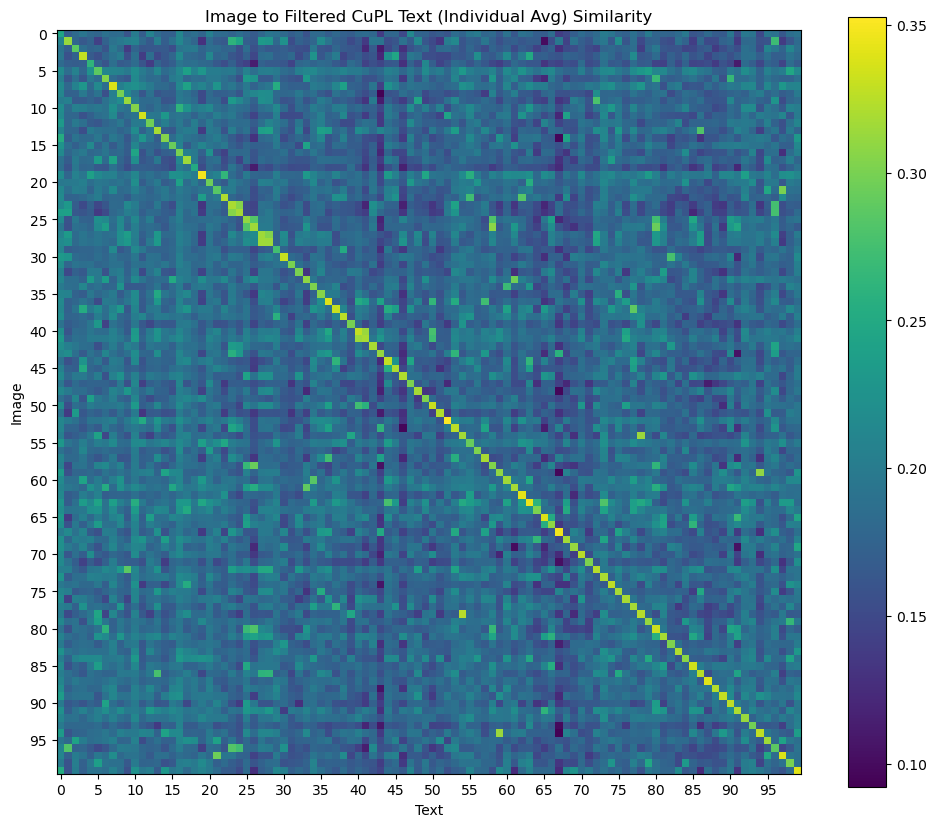

Rank 1: (21)(Image)chair - (97)(Text)windsor_chair, error rate: 0.7894736842105263
Rank 2: (96)(Image)wild_cat - (1)(Text)leopard, error rate: 0.5
Rank 3: (28)(Image)crocodile_head - (27)(Text)crocodile, error rate: 0.4666666666666667
Rank 4: (59)(Image)lotus - (94)(Text)water_lilly, error rate: 0.45
Rank 5: (78)(Image)schooner - (54)(Text)ketch, error rate: 0.3888888888888889
Rank 6: (58)(Image)lobster - (26)(Text)crayfish, error rate: 0.3076923076923077
Rank 7: (41)(Image)flamingo_head - (40)(Text)flamingo, error rate: 0.2857142857142857
Rank 8: (54)(Image)ketch - (78)(Text)schooner, error rate: 0.2647058823529412
Rank 9: (33)(Image)dragonfly - (61)(Text)mayfly, error rate: 0.25
Rank 10: (26)(Image)crayfish - (58)(Text)lobster, error rate: 0.23809523809523808
Rank 11: (96)(Image)wild_cat - (23)(Text)cougar_body, error rate: 0.2
Rank 12: (29)(Image)cup - (38)(Text)ewer, error rate: 0.16666666666666666
Rank 13: (10)(Image)binocular - (51)(Text)inline_skate, error rate: 0.1
Rank 14: (43

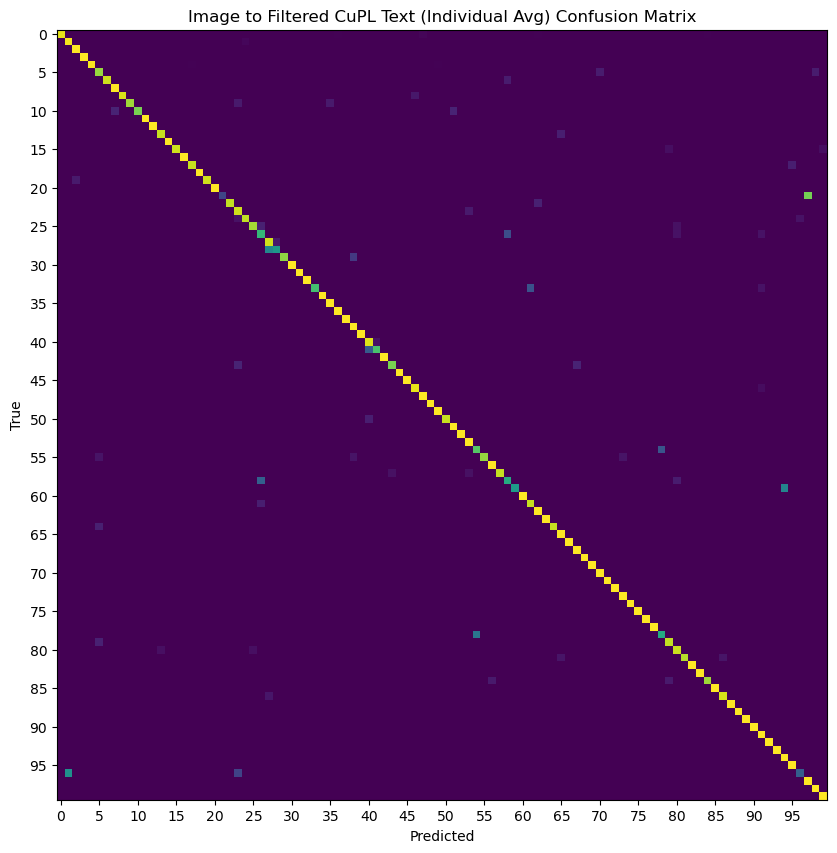

In [41]:
# @title Similarity Of Classes (Image vs Filtered CuPL)
visualize_cross_similarity(calc_features_similarity(img_features_cuda, filtered_cupl_cls_features_cuda), filtered_cupl_cls_cm, 'Image to Filtered CuPL Text (Centroid)')
visualize_cross_similarity(calc_features_similarity(img_features_cuda, filtered_cupl_text_features_cuda), filtered_cupl_text_cm, 'Image to Filtered CuPL Text (Individual Avg)')

# Visualization of Features Using t-SNE

## Dimensionality Reduction Using t-SNE

In [42]:
# Concatenate all features and labels to be used for plotting
all_label_ids = np.concatenate([cls_name_label_ids, template_label_ids, original_cupl_label_ids, filtered_cupl_label_ids])
all_features = np.concatenate([cls_name_features, template_text_features, original_cupl_text_features, filtered_cupl_text_features])

cls_name_start_idx = 0
cls_name_end_idx = len(cls_name_features)
template_start_idx = len(cls_name_features)
template_end_idx = len(cls_name_features) + len(template_text_features)
original_cupl_start_idx = len(cls_name_features) + len(template_text_features)
original_cupl_end_idx = len(cls_name_features) + len(template_text_features) + len(original_cupl_text_features)
filtered_cupl_start_idx = len(cls_name_features) + len(template_text_features) + len(original_cupl_text_features)
filtered_cupl_end_idx = len(cls_name_features) + len(template_text_features) + len(original_cupl_text_features) + len(filtered_cupl_text_features)

In [43]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=42, metric='cosine', perplexity=100)
transformed_features = tsne.fit_transform(all_features)

In [44]:
def calc_centroid(features, label_ids):
    return [features[label_ids == label_id].mean(axis=0) for label_id in range(len(cls_names_sorted))]

In [45]:
cls_name_transformed_features = transformed_features[cls_name_start_idx:cls_name_end_idx]
cls_name_transformed_label_ids = all_label_ids[cls_name_start_idx:cls_name_end_idx]
cls_name_transformed_centroids = calc_centroid(cls_name_transformed_features, cls_name_transformed_label_ids)
template_transformed_features = transformed_features[template_start_idx:template_end_idx]
template_transformed_label_ids = all_label_ids[template_start_idx:template_end_idx]
template_transformed_centroids = calc_centroid(template_transformed_features, template_transformed_label_ids)
original_cupl_transformed_features = transformed_features[original_cupl_start_idx:original_cupl_end_idx]
original_cupl_transformed_label_ids = all_label_ids[original_cupl_start_idx:original_cupl_end_idx]
original_cupl_transformed_centroids = calc_centroid(original_cupl_transformed_features, original_cupl_transformed_label_ids)
filtered_cupl_transformed_features = transformed_features[filtered_cupl_start_idx:filtered_cupl_end_idx]
filtered_cupl_transformed_label_ids = all_label_ids[filtered_cupl_start_idx:filtered_cupl_end_idx]
filtered_cupl_transformed_centroids = calc_centroid(filtered_cupl_transformed_features, filtered_cupl_transformed_label_ids)

In [46]:
def plot_features_2d(features, label_ids, title):
    plt.figure(figsize=(10, 10))
    plt.scatter(features[:, 0], features[:, 1], c=label_ids, cmap='hsv')
    for label_id in range(len(cls_names_sorted)):
        plt.annotate(label_id, (features[label_ids == label_id, 0].mean(), features[label_ids == label_id, 1].mean()), ha='center', va='center', fontsize=12)
    plt.title(title)
    plt.show()

## Visualizations

Rank 1: (27)crocodile(coor=-13,-14) - (28)crocodile_head(coor=-13,-14), similarity: 0.94677734375
Rank 2: (23)cougar_body(coor=4,-40) - (24)cougar_face(coor=4,-40), similarity: 0.923828125
Rank 3: (40)flamingo(coor=-63,8) - (41)flamingo_head(coor=-63,8), similarity: 0.90966796875
Rank 4: (25)crab(coor=-27,25) - (26)crayfish(coor=-27,25), similarity: 0.8984375
Rank 5: (0)face(coor=13,-6) - (12)brain(coor=13,-6), similarity: 0.89208984375
Rank 6: (21)chair(coor=52,1) - (95)wheelchair(coor=52,1), similarity: 0.89013671875
Rank 7: (0)face(coor=13,-6) - (24)cougar_face(coor=13,-6), similarity: 0.89013671875
Rank 8: (25)crab(coor=-27,25) - (58)lobster(coor=-27,25), similarity: 0.8837890625
Rank 9: (15)butterfly(coor=-10,9) - (33)dragonfly(coor=-10,9), similarity: 0.8818359375
Rank 10: (26)crayfish(coor=-23,29) - (58)lobster(coor=-23,29), similarity: 0.8798828125


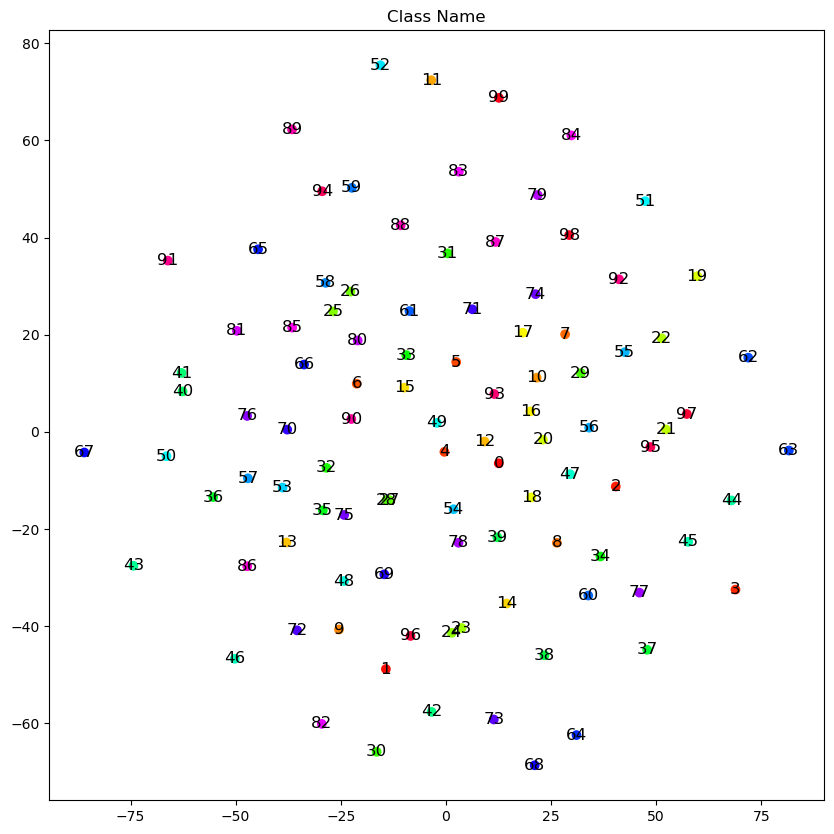

In [47]:
# @title Class Name Text Features
print_top_pairs(np.triu(cls_name_masked_similarity, k=1), 'similarity', coordinates=cls_name_transformed_centroids)
plot_features_2d(cls_name_transformed_features, cls_name_transformed_label_ids, 'Class Name')

Rank 1: (27)crocodile(coor=-14,-14) - (28)crocodile_head(coor=-14,-14), similarity: 0.955078125
Rank 2: (40)flamingo(coor=-61,9) - (41)flamingo_head(coor=-61,9), similarity: 0.9287109375
Rank 3: (23)cougar_body(coor=4,-41) - (24)cougar_face(coor=4,-41), similarity: 0.91748046875
Rank 4: (26)crayfish(coor=-22,27) - (58)lobster(coor=-22,27), similarity: 0.89990234375
Rank 5: (25)crab(coor=-27,23) - (26)crayfish(coor=-27,23), similarity: 0.89453125
Rank 6: (25)crab(coor=-27,23) - (58)lobster(coor=-27,23), similarity: 0.89453125
Rank 7: (16)camera(coor=19,4) - (20)cellphone(coor=19,4), similarity: 0.890625
Rank 8: (4)airplane(coor=-0,-2) - (49)helicopter(coor=-0,-2), similarity: 0.890625
Rank 9: (21)chair(coor=52,1) - (95)wheelchair(coor=52,1), similarity: 0.888671875
Rank 10: (0)face(coor=12,-6) - (12)brain(coor=12,-6), similarity: 0.88818359375


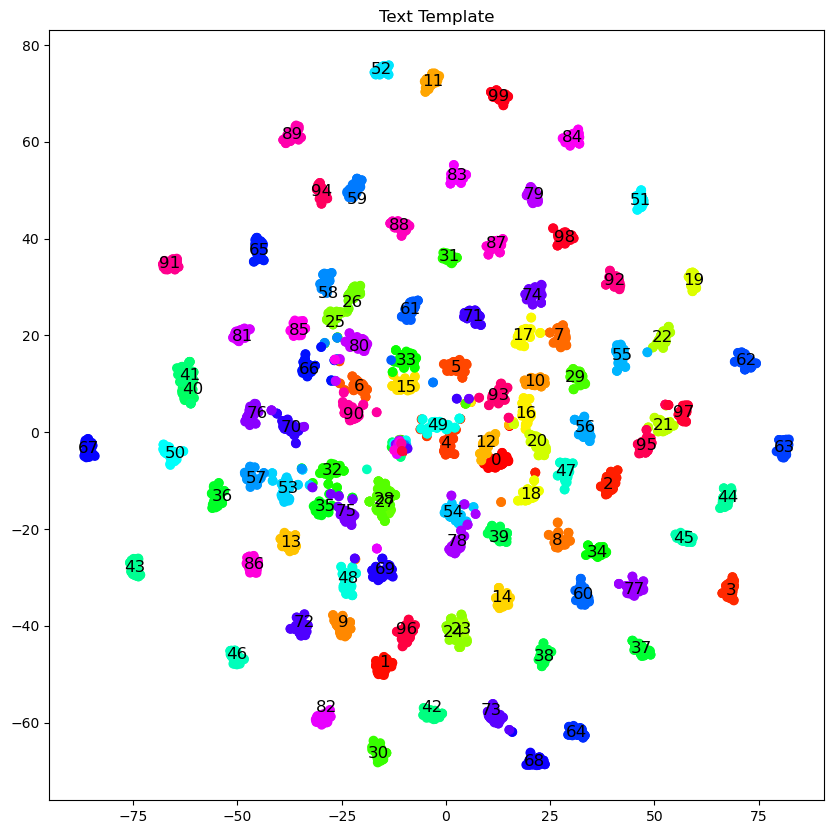

In [48]:
# @title 80 Templates Text Features
print_top_pairs(np.triu(template_masked_similarity, k=1), 'similarity', coordinates=template_transformed_centroids)
plot_features_2d(template_transformed_features, template_transformed_label_ids, 'Text Template')

Rank 1: (27)crocodile(coor=-10,-16) - (28)crocodile_head(coor=-10,-16), similarity: 0.9716796875
Rank 2: (23)cougar_body(coor=-3,-43) - (24)cougar_face(coor=-3,-43), similarity: 0.96142578125
Rank 3: (40)flamingo(coor=-65,8) - (41)flamingo_head(coor=-65,8), similarity: 0.9169921875
Rank 4: (54)ketch(coor=1,-19) - (78)schooner(coor=1,-19), similarity: 0.9150390625
Rank 5: (26)crayfish(coor=-23,31) - (58)lobster(coor=-23,31), similarity: 0.9111328125
Rank 6: (23)cougar_body(coor=-3,-43) - (96)wild_cat(coor=-3,-43), similarity: 0.908203125
Rank 7: (25)crab(coor=-27,26) - (58)lobster(coor=-27,26), similarity: 0.90576171875
Rank 8: (24)cougar_face(coor=-2,-44) - (96)wild_cat(coor=-2,-44), similarity: 0.89990234375
Rank 9: (59)lotus(coor=-25,52) - (94)water_lilly(coor=-25,52), similarity: 0.8984375
Rank 10: (35)elephant(coor=-30,-18) - (75)rhino(coor=-30,-18), similarity: 0.89794921875


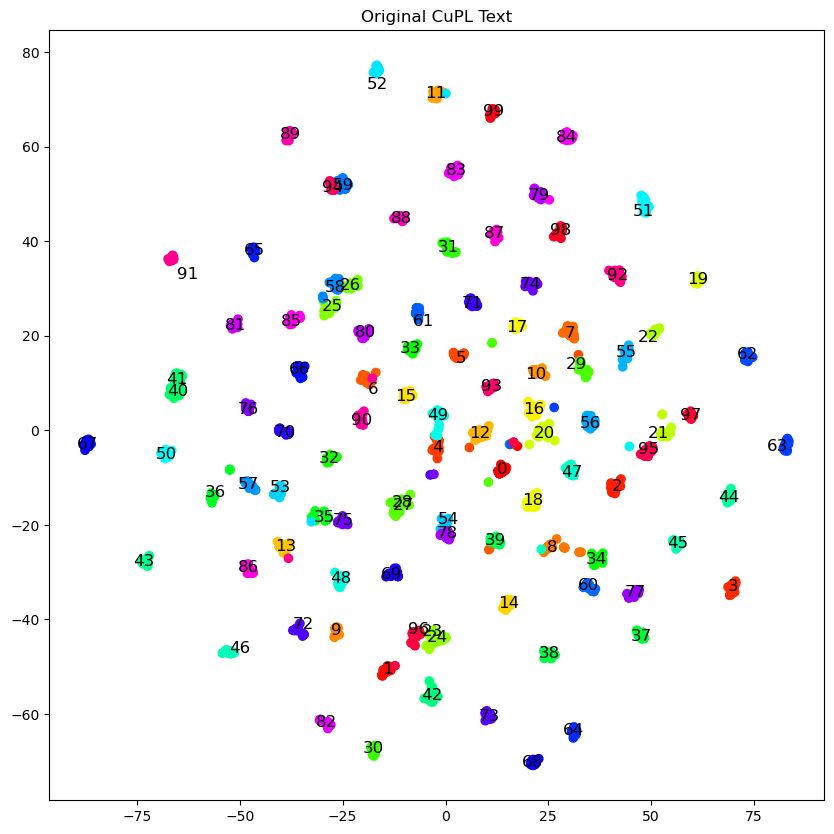

In [49]:
# @title Original CuPL Text Features
print_top_pairs(np.triu(original_cupl_masked_similarity, k=1), 'similarity', coordinates=original_cupl_transformed_centroids)
plot_features_2d(original_cupl_transformed_features, original_cupl_transformed_label_ids, 'Original CuPL Text')

Rank 1: (27)crocodile(coor=-10,-16) - (28)crocodile_head(coor=-10,-16), similarity: 0.9716796875
Rank 2: (23)cougar_body(coor=-3,-42) - (24)cougar_face(coor=-3,-42), similarity: 0.9619140625
Rank 3: (40)flamingo(coor=-65,8) - (41)flamingo_head(coor=-65,8), similarity: 0.91748046875
Rank 4: (54)ketch(coor=0,-19) - (78)schooner(coor=0,-19), similarity: 0.91357421875
Rank 5: (26)crayfish(coor=-23,31) - (58)lobster(coor=-23,31), similarity: 0.91357421875
Rank 6: (25)crab(coor=-27,26) - (58)lobster(coor=-27,26), similarity: 0.90771484375
Rank 7: (23)cougar_body(coor=-3,-42) - (96)wild_cat(coor=-3,-42), similarity: 0.90771484375
Rank 8: (35)elephant(coor=-29,-18) - (75)rhino(coor=-29,-18), similarity: 0.89990234375
Rank 9: (59)lotus(coor=-25,52) - (94)water_lilly(coor=-25,52), similarity: 0.89794921875
Rank 10: (24)cougar_face(coor=-2,-44) - (96)wild_cat(coor=-2,-44), similarity: 0.89794921875


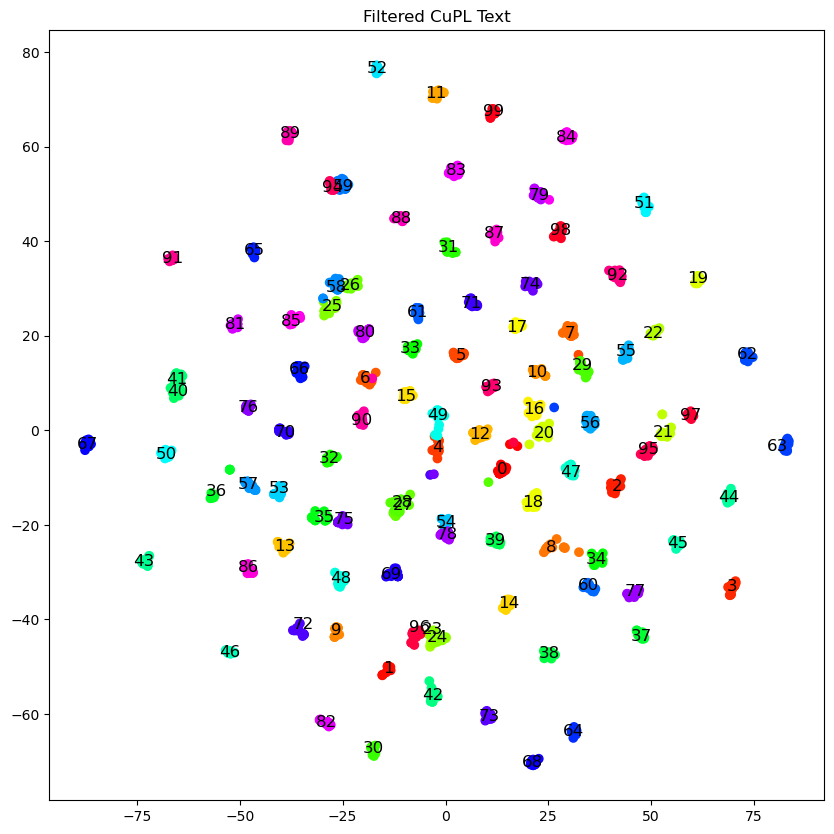

In [50]:
# @title Filtered CuPL Text Features
print_top_pairs(np.triu(filtered_cupl_masked_similarity, k=1), 'similarity', coordinates=filtered_cupl_transformed_centroids)
plot_features_2d(filtered_cupl_transformed_features, filtered_cupl_transformed_label_ids, 'Filtered CuPL Text')